# ПРОЕКТ: ПРОГНОЗ УДОЯ КОРОВ И ВКУСА МОЛОКА

**ОПИСАНИЕ ПРОЕКТА**

Заказчик проекта - молочное хозяйство "Вольный луг", которое хочет купить бурёнок для расширения поголовья стада коров.
Данные представлены тремя датасетами:
 - ferma_main.csv - с данными о стаде фермера на текущий момент
 - ferma_dad.сым - хранит имя папы каждой коровы в стаде фермера
 - cow_buy.csv - с данными о коровах, представленных для потенциальной покупки

**ЗАДАЧА ПРОЕКТА**

Задача прокта - разработать модель машинного обучения, которая поможет заказчику управлять рисками и принимать объективное решение о покупке коров по предоставленным подробным данным о коровах. Необходимо создать две прогнозные модели для отбора бурёнок в поголовье:

1.	Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
2.	Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).
  
С помощью модели нужно отобрать коров по двум критериям:
 -  средний удой за год — не менее 6000 килограммов;
 -  молоко должно быть вкусным.

**ПЛАН ПРОЕКТА**

1. [Загрузка и изучение данных](#1)
2. [Предобработка данных](#2)
3. [Исследовательский анализ данных](#3)
4. [Корреляционных анализ признаков в датасете](#4)
5. [Задача регрессии](#5)
6. [Задача классификации](#6)
7. [Итоги](#7)

<a id='1'></a>
## Загрузка и изучение данных

### Получение данных из файлов, запись в датафреймы

In [1]:
!pip install jupyter_black -q

In [2]:
!pip install phik -q

In [43]:
!pip install -Uq scikit-learn

Импортируем необходимые библиотеки

In [81]:
# импорт pandas и необходимых библиотек
import jupyter_black
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import phik
import seaborn as sns
import warnings

from joblib import dump, load
from scipy import stats as st
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    recall_score,
    root_mean_squared_error,
    r2_score,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from matplotlib.colors import LinearSegmentedColormap

warnings.filterwarnings("ignore")

jupyter_black.load()

RANDOM_STATE = 42

Откроем файлы, прочтем и запишем в переменные.

In [4]:
# объявление переменных
main_file = "dataset_main.csv"
dad_file = "dataset_dad.csv"
cow_file = "dataset_cow.csv"
user_path = "..."
general_path = "..."


# функция для чтения файлов
def get_read_file(general_path, user_path, file):
    path1 = os.path.join(general_path, file)
    path2 = os.path.join(user_path, file)

    try:
        if os.path.exists(os.path.join(path1)):
            return pd.read_csv(path1, sep=";", decimal=",")
        elif os.path.exists(os.path.join(path2)):
            return pd.read_csv(path2, sep=";", decimal=",")
    except Exception as err:
        print("Путь к файлу не найден!", err)


# чтение csv-файла в датафрейм с сохранением в переменную main_df
main_df = get_read_file(general_path, user_path, main_file)
main_df.name = "main_df"
# чтение csv-файла в датафрейм с сохранением в переменную dad_df
dad_df = get_read_file(general_path, user_path, dad_file)
dad_df.name = "dad_df"
# чтение csv-файла в датафрейм с сохранением в переменную cow_df
cow_df = get_read_file(general_path, user_path, cow_file)
cow_df.name = "cow_df"
# сохранение количества строк в переменную
main_rows_before = main_df.shape[0]

### Изучение данных

Изучим общую информацию о полученных датафреймах

In [6]:
# объявление списка датафреймов
df_lst = [main_df, dad_df, cow_df]


# функции для вывода информации о датафреймах
def get_method(method):
    return [getattr(df, method) for df in df_lst]


def get_info(df_lst, get_method, flag=True):
    i = 0
    for df in df_lst:
        print(f"Датафрейм - {df.name}")
        print("---------")
        if flag:
            display(get_method[i]())
        else:
            get_method[i]()
        print("")
        i += 1


# вывод первых 5-ти строчек датафреймов
get_info(df_lst, get_method("head"))

Датафрейм - main_df
---------


,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет



Датафрейм - dad_df
---------


,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин



Датафрейм - cow_df
---------


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [8]:
# вывод основной информации о датафреймах
get_info(df_lst, get_method("info"), flag=False)

Датафрейм - main_df
---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 n

Обратим внимание на наименования столбцов в датафреймах

In [9]:
# вывод наименований столбцов в датафреймах
for df in df_lst:
    print("")
    print(f"Датафрейм - {df.name}")
    print("---------")
    print(*df.columns.tolist(), sep="\n")


Датафрейм - main_df
---------
id
Удой, кг
ЭКЕ (Энергетическая кормовая единица)
Сырой протеин, г
СПО (Сахаро-протеиновое соотношение)
Порода
Тип пастбища
порода папы_быка
Жирность,%
Белок,%
Вкус молока
Возраст

Датафрейм - dad_df
---------
id
Имя Папы

Датафрейм - cow_df
---------
Порода
Тип пастбища
порода папы_быка
Имя_папы
Текущая_жирность,%
Текущий_уровень_белок,%
Возраст


Переименуем столбцы:
 - приведём наименования столбцов к нижнему регистру
 - удалим символы: запятая, скобка, знак процентов
 - слова соединим нижним подчёркиванием
 - удалим расшифровки аббревиатур

In [11]:
# функция для переименования столбцов в датафреймах
def rename_columns(df):
    lst_columns = df.columns.to_list()
    new_lst_columns = []
    for col in lst_columns:
        col = col.lower()
        if col.find(" (") != -1:
            ind = col.find(" (")
            col = col[:ind]
        if col.find(",%") != -1:
            ind = col.find(",%")
            col = col[:ind]
        old_elem = (", ", ",", " ")
        for elem in old_elem:
            col = col.replace(elem, "_")
        new_lst_columns.append(col)
    df.columns = new_lst_columns


# переименование столбцов
for df in df_lst:
    rename_columns(df)
# проверка переименования
get_info(df_lst, get_method("info"), flag=False)

Датафрейм - main_df
---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                634 non-null    int64  
 1   удой_кг           634 non-null    int64  
 2   эке               634 non-null    float64
 3   сырой_протеин_г   634 non-null    int64  
 4   спо               634 non-null    float64
 5   порода            634 non-null    object 
 6   тип_пастбища      634 non-null    object 
 7   порода_папы_быка  634 non-null    object 
 8   жирность          634 non-null    float64
 9   белок             634 non-null    float64
 10  вкус_молока       634 non-null    object 
 11  возраст           634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB

Датафрейм - dad_df
---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Colum

**Вывод:**

1. Данные были загружены в датасеты.
2. В результате изучения общей информации о датафрейме обнаружено некорректное наименование столбцов:
    - сочетание прописных и строчных букв
    - есть слова, разделенные пробелами
    - используются знаки препинания: запятые и скобки, и знак процентов
    - стиль написания, отличный от "lower_case_with_underscores"
3. Наименования столбцов приведены к стандартам оформления данных.

<a id='2'></a>
## Предобработка данных

### Предобработка пропусков и явных дубликатов

Выведем количество явных дубликатов

In [12]:
# вывод количества явных дубликатов датафреймов
for df in df_lst:
    print("")
    print(f"Датафрейм - {df.name}")
    print(df.duplicated().sum())


Датафрейм - main_df
5

Датафрейм - dad_df
0

Датафрейм - cow_df
4


Удалим выявленные явные дубликаты в датафрейме **main_df**

In [13]:
# удаление явных дубликатов
main_df.drop_duplicates(inplace=True)

Проверим данные на пропущенные значения

In [15]:
# вывод количества пропущенных значений
print(main_df.isna().sum().sum())

0


В датасете **cow_df** данных мало, признаков мало, поэтому вероятность повторов коров ненулевая.\
Поэтому дубликаты в датасете **cow_df** удалять не будем.

### Предобработка типов данных

Обратим внимание на типы данных в таблице

In [16]:
# вывод типов данных в столбцах в датафреймах
for df in df_lst:
    print("")
    print(f"Датафрейм - {df.name}")
    print("---------")
    print(df.dtypes)


Датафрейм - main_df
---------
id                    int64
удой_кг               int64
эке                 float64
сырой_протеин_г       int64
спо                 float64
порода               object
тип_пастбища         object
порода_папы_быка     object
жирность            float64
белок               float64
вкус_молока          object
возраст              object
dtype: object

Датафрейм - dad_df
---------
id           int64
имя_папы    object
dtype: object

Датафрейм - cow_df
---------
порода                    object
тип_пастбища              object
порода_папы_быка          object
имя_папы                  object
текущая_жирность         float64
текущий_уровень_белок    float64
возраст                   object
dtype: object


### Предобработка неявных дубликатов

Проверим данные на наличие неявных дубликатов.\
Выведем значения в колонках со строковым типом данных для датафрейма **main_df**

In [17]:
# объявление функции для вывода значений столбцов со строковым типом данных
def get_str_values(df):
    obj_lst = df.select_dtypes(include="object").columns.to_list()
    print(df.name)
    print("---------")
    for col in obj_lst:
        print("---------")
        print(df[col].value_counts())


# вызов функции для датафрейма main_df
get_str_values(main_df)

main_df
---------
---------
порода
Вис Бик Айдиал     373
РефлешнСоверинг    256
Name: count, dtype: int64
---------
тип_пастбища
Холмистое    351
Равнинное    253
Равнинные     25
Name: count, dtype: int64
---------
порода_папы_быка
Соверин    311
Айдиал     240
Айдиалл     78
Name: count, dtype: int64
---------
вкус_молока
вкусно       371
не вкусно    258
Name: count, dtype: int64
---------
возраст
более_2_лет    519
менее_2_лет    110
Name: count, dtype: int64


Выведем значения в колонках со строковым типом данных для датафрейма **cow_df**

In [18]:
# вызов функции для датафрейма cow_df
get_str_values(cow_df)

cow_df
---------
---------
порода
РефлешнСоверинг    11
Вис Бик Айдиал      9
Name: count, dtype: int64
---------
тип_пастбища
равнинное    11
холмистое     9
Name: count, dtype: int64
---------
порода_папы_быка
Соверин    12
Айдиал      8
Name: count, dtype: int64
---------
имя_папы
Буйный      8
Геркулес    6
Барин       4
Соловчик    2
Name: count, dtype: int64
---------
возраст
более_2_лет    15
менее_2_лет     5
Name: count, dtype: int64


В датафреймах **main_df** и **cow_df** колонки `'тип_пастбища'` содержат только 2 значения:
 - холмистое
 - равнинное

Однако в датафрейме **main_df** значения записаны не так, как в датафрейме **cow_df**:
 - с большой буквы
 - присутствует значение "Равнинные" вместо "равнинное"

Приведем значения к нормальному виду

In [19]:
# замена значений в столбце
main_df["тип_пастбища"] = (
    main_df["тип_пастбища"].str.lower().replace("равнинные", "равнинное")
)

В датафреймах **main_df** и **cow_df** колонки `'порода_папы_быка'`
 - Соверин
 - Айдиал

Однако в датафрейме **main_df** присутствует значение "Айдиалл" вместо "Айдиал"

Приведем значения к нормальному виду

In [20]:
# замена значений в столбце
main_df["порода_папы_быка"] = main_df["порода_папы_быка"].replace("Айдиалл", "Айдиал")

Выведем значения для датафрейма **dad_df**

In [21]:
# вызов функции для датафрейма cow_df
get_str_values(dad_df)

dad_df
---------
---------
имя_папы
Барин       240
Буйный      215
Соловчик    110
Геркулес     64
Name: count, dtype: int64


**Вывод:**

1. Были обнаружены и удалены явные дубликаты в датафреймах:
   - в **main_df** - 5 дубликатов
   - в **cow_df** - 4 дубликата
2. Пропусков в значениях датафреймов не обнаружено.
3. Были обнаружены и исправлены неявные дубликаты\
   в **main_df** - в столбцах `'тип_пастбища'` и `'порода_папы_быка'`
4. Значения в столбце `'тип_пастбища'` датафрейма **main_df** были приведены к общему с датафреймом **cow_df** виду.

<a id='3'></a>
## Исследовательский анализ данных

### Статистический анализ признаков

#### Статистический анализ признаков датасета **main_df**

Проведем статистический анализ признаков датасета **main_df**

Выведем описательную статистику для количественных признаков датасета

In [22]:
# создание списка количественных признаков
main_num_lst = main_df.select_dtypes(include=["float", "int"]).columns.to_list()
main_num_lst.remove("id")

# создание списка категориальных признаков
main_categ_lst = main_df.select_dtypes(include=["object"]).columns.to_list()

# вывод описательной статистики для количественных признаков датасета
main_df[[*main_num_lst]].describe().round(3)

,удой_кг,эке,сырой_протеин_г,спо,жирность,белок
count,629.000,629.000,629.000,629.000,629.000,629.000
mean,6188.750,14.544,1923.364,0.913,3.604,3.076
std,1644.795,1.306,182.956,0.032,0.169,0.003
min,5204.000,10.900,1660.000,0.840,2.990,3.069
25%,5751.000,13.500,1771.000,0.890,3.590,3.074
50%,6133.000,14.700,1888.000,0.930,3.650,3.076
75%,6501.000,15.600,2062.000,0.940,3.720,3.077
max,45616.000,16.800,2349.000,0.960,3.750,3.085


1. У признака `'удой_кг'` заметен явный разброс значений:\
   от 5204 до 45616 при среднем ~ 6189
2. У признака `'эке'` среднее (14.544) и медиана (14.7) достаточно близки,\
   хотя стандартное отклонение составляет 1.306
3. У признака `'сырой_протеин_г'` среднее (1923.364) и медиана (1888) ощутимо отличаются,\
   и стандартное отклонение существенно (182.956)
4. У признака `'спо'` стандартное отклонение невелико (0.032),\
   а среднее (0.913) и медиана (0.93) близки по значению.
5. У признака `'жирность'` среднее (3.604) и медиана (3.65) достаточно близки,\
   хотя стандартное отклонение составляет 0.169
6. У признака `'белок'` стандартное отклонение очень малО (0.002549)\
   а среднее значение (3.076) и медиана (3.075671) почти не отличаются.

Для большей наглядности построим диаграммы размаха для количественных признаков датасета.

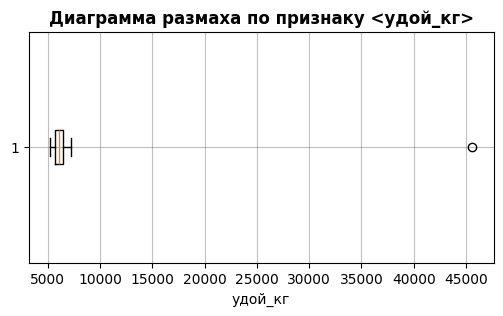

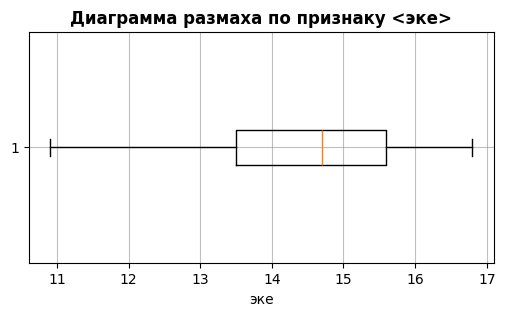

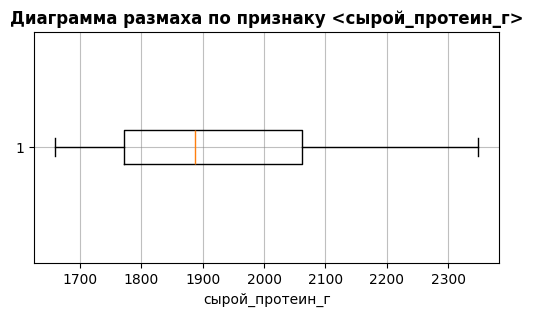

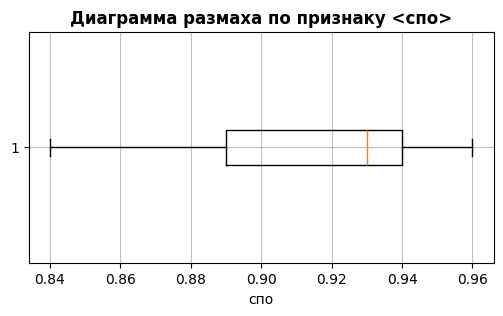

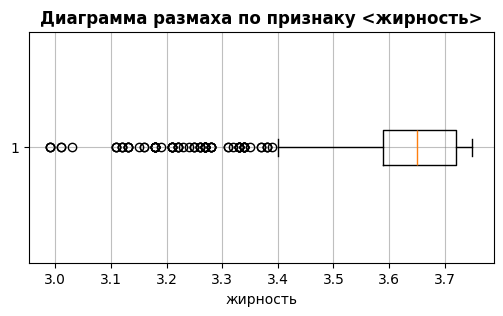

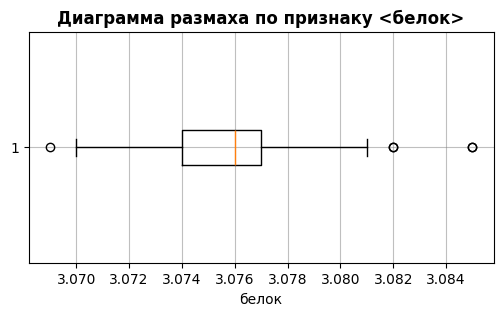

In [23]:
# функция для построения диаграммы размаха
def get_boxplot(df, item):
    plt.rcParams["figure.figsize"] = (
        6,
        3,
    )  # установка параметров графика: размер фигуры

    plt.boxplot(df[item], vert=False)
    plt.title(
        f"Диаграмма размаха по признаку <{item}>",
        weight="bold",
    )
    plt.xlabel(f"{item}")
    plt.grid(color="grey", axis="both", alpha=0.5)
    plt.show()


# построение графиков
def set_plot(df, item_lst, plot):
    for item in item_lst:
        plot(df, item)


# построение диаграммы размаха для количественных признаков датасета
set_plot(main_df, main_num_lst, get_boxplot)

На диаграммах размаха видно:
1. по признаку `'удой_кг'` - 1 выброс, который сильно искажает данные.
2. по признаку `'жирность'` - много выбросов ниже края статистически значимой выборки.
3. по признаку `'белок'` - 3 выброса.

Посмотрим, какое количество записей в датасете приходится на выбросы по признакам `'удой_кг'` и `'белок'`

In [24]:
# вывод записей по условию
main_df.query("удой_кг > 10000 | белок >= 3.0815 | белок < 3.07")

,id,удой_кг,эке,сырой_протеин_г,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
16,17,45616,11.5,1675,0.930,Вис Бик Айдиал,холмистое,Айдиал,3.22,3.076,вкусно,более_2_лет
77,78,5871,14.7,1795,0.895,Вис Бик Айдиал,равнинное,Айдиал,3.61,3.082,вкусно,более_2_лет
240,241,5568,13.4,1733,0.880,Вис Бик Айдиал,равнинное,Соверин,3.63,3.069,не вкусно,менее_2_лет
426,427,6701,15.7,2068,0.940,РефлешнСоверинг,холмистое,Айдиал,3.72,3.082,вкусно,более_2_лет
471,472,5883,14.9,2159,0.890,Вис Бик Айдиал,равнинное,Соверин,3.62,3.085,вкусно,более_2_лет
517,518,5819,13.7,1968,0.840,Вис Бик Айдиал,холмистое,Айдиал,3.15,3.085,вкусно,более_2_лет


Всего 6 записей - такое количество записей можно удалить без потери репрезентативности данных.

Посмотрим, какое количество записей в датасете приходится на выбросы по признаку `'жирность'`

In [25]:
# вывод записей по условию
main_df.query("жирность < 3.4")

,id,удой_кг,эке,сырой_протеин_г,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
5,6,5254,12.7,1806,0.885,РефлешнСоверинг,холмистое,Соверин,3.13,3.078,вкусно,менее_2_лет
9,10,5339,13.4,1791,0.895,Вис Бик Айдиал,холмистое,Соверин,3.13,3.075,вкусно,менее_2_лет
10,11,5591,13.7,1678,0.895,РефлешнСоверинг,холмистое,Айдиал,3.13,3.075,вкусно,менее_2_лет
16,17,45616,11.5,1675,0.930,Вис Бик Айдиал,холмистое,Айдиал,3.22,3.076,вкусно,более_2_лет
17,18,5777,12.4,1873,0.895,Вис Бик Айдиал,холмистое,Айдиал,3.03,3.080,вкусно,более_2_лет
...,...,...,...,...,...,...,...,...,...,...,...,...
587,588,5610,14.7,1671,0.880,Вис Бик Айдиал,равнинное,Айдиал,3.18,3.079,не вкусно,более_2_лет
589,590,5213,12.1,2016,0.880,РефлешнСоверинг,равнинное,Соверин,3.19,3.076,не вкусно,менее_2_лет
591,592,5520,11.9,1785,0.880,Вис Бик Айдиал,равнинное,Соверин,3.12,3.073,не вкусно,менее_2_лет
602,603,5594,12.3,1742,0.880,Вис Бик Айдиал,равнинное,Айдиал,3.11,3.077,вкусно,менее_2_лет


87 записей - это большое количество. Такое количество записей нельзя удалять при построении модели.\
Удалим данные только по признакам `'удой_кг'` и `'белок'`

In [26]:
# вывод записей по условию
clear_df = main_df.query("~(удой_кг > 10000) & ~(белок >= 3.0815) & ~(белок < 3.07)")

# вывод описательной статистики
clear_df.describe()

,id,удой_кг,эке,сырой_протеин_г,спо,жирность,белок
count,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000,623.000000
mean,315.219904,6127.232745,14.549278,1923.592295,0.913283,3.604735,3.075631
std,181.584881,476.314531,1.304837,182.991260,0.032150,0.167712,0.002466
min,1.000000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.070000
25%,158.500000,5748.500000,13.500000,1771.500000,0.890000,3.590000,3.074000
50%,315.000000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.000000,6501.000000,15.600000,2060.500000,0.940000,3.720000,3.077000
max,629.000000,7222.000000,16.800000,2349.000000,0.960000,3.750000,3.081000


Выведем информацию о количестве удаленных данных.

In [27]:
print(f"Датафрейм содержит {clear_df.shape[0]} строк.")
print(f"Первоначальный датафрейм содержал {main_rows_before} строк.")
print(f"Удалено {main_rows_before-clear_df.shape[0]} строк.")
print(
    f"Это примерно {round(100-(clear_df.shape[0]/main_rows_before*100), 2)}% от первоначального размера датафрейма."
)

Датафрейм содержит 623 строк.
Первоначальный датафрейм содержал 634 строк.
Удалено 11 строк.
Это примерно 1.74% от первоначального размера датафрейма.


Удалено менее 2 % строк датасета - это допустимое значение.

Выведем описательную статистику для категориальных признаков датасета

In [28]:
# вывод описательной статистики для категориальных признаков датасета
main_df[[*main_categ_lst]].describe().round(3)

,порода,тип_пастбища,порода_папы_быка,вкус_молока,возраст
count,629,629,629,629,629
unique,2,2,2,2,2
top,Вис Бик Айдиал,холмистое,Айдиал,вкусно,более_2_лет
freq,373,351,318,371,519


Во всех столбцах датафрейма с категориальными данными по 2 значения

#### Статистический анализ признаков датасета **cow_df**

Проведём статистический анализ признаков датасета **cow_df**

In [29]:
# создание списка количественных признаков
cow_num_lst = cow_df.select_dtypes(include=["float", "int"]).columns.to_list()

# создание списка категориальных признаков
cow_categ_lst = cow_df.select_dtypes(include=["object"]).columns.to_list()

# вывод описательной статистики для количественных признаков датасета
cow_df[[*cow_num_lst]].describe().round(3)

,текущая_жирность,текущий_уровень_белок
count,20.000,20.000
mean,3.577,3.070
std,0.127,0.010
min,3.340,3.046
25%,3.510,3.064
50%,3.590,3.074
75%,3.650,3.076
max,3.770,3.081


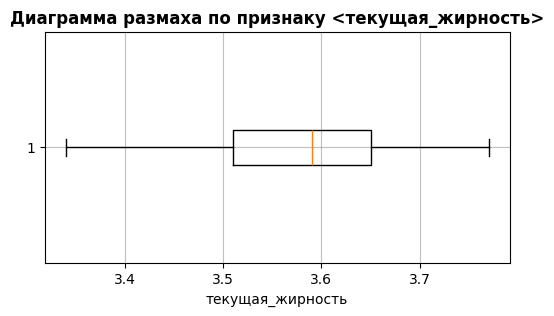

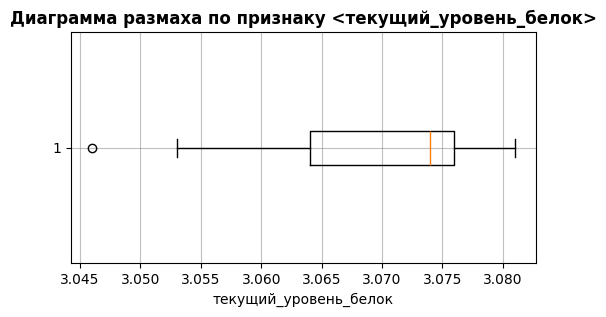

In [30]:
# построение диаграммы размаха для количественных признаков датасета
set_plot(cow_df, cow_num_lst, get_boxplot)

В данных датасета **cow_df** выбросов не наблюдается.

In [31]:
# вывод описательной статистики для категориальных признаков датасета
cow_df[[*cow_categ_lst]].describe().round(3)

,порода,тип_пастбища,порода_папы_быка,имя_папы,возраст
count,20,20,20,20,20
unique,2,2,2,4,2
top,РефлешнСоверинг,равнинное,Соверин,Буйный,более_2_лет
freq,11,11,12,8,15


Во всех столбцах датафрейма с категориальными данными по 2 значения, кроме столбца `'имя_папы'` - 4 значения.

### Построение графиков для признаков

#### Построение графиков для признаков датасета **main_df**

Для количественных признаков датасета построим гистограммы

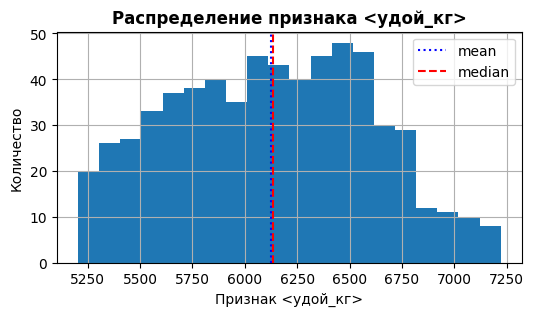

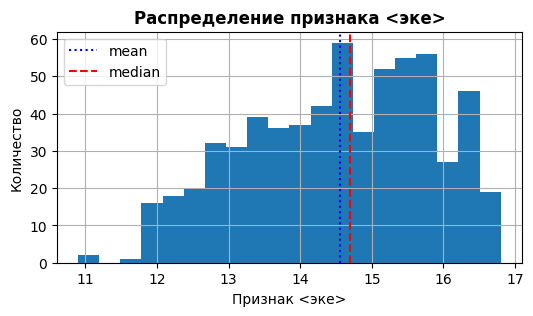

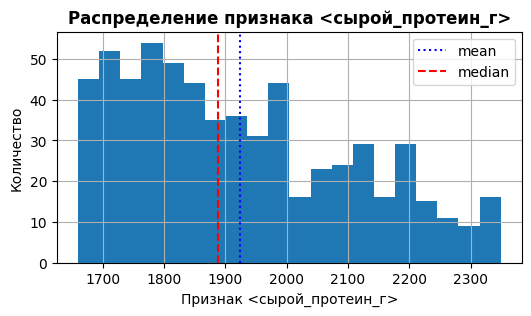

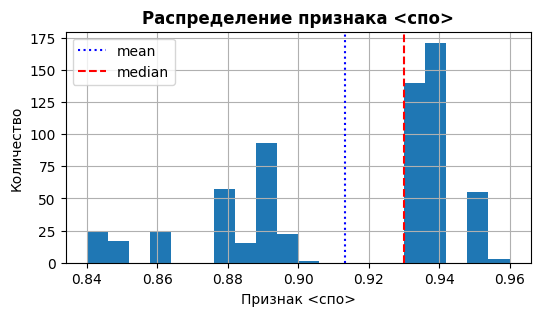

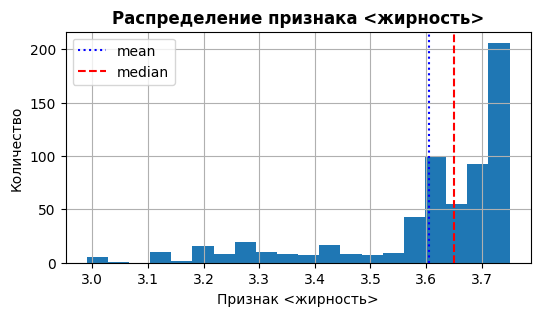

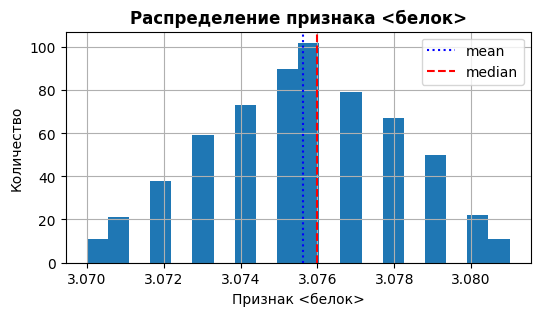

In [32]:
# функция для построения гистограммы
def get_hist(df, item):
    mean_value = df[item].mean()
    median_value = df[item].median()
    df[item].hist(bins=20)
    plt.title(f"Распределение признака <{item}>", weight="bold")
    plt.xlabel(f"Признак <{item}>")
    plt.ylabel("Количество")
    plt.axvline(x=mean_value, label="mean", color="b", linestyle=":")
    plt.axvline(x=median_value, label="median", color="r", linestyle="--")
    plt.legend()
    plt.show()


# построение гистограммы
set_plot(clear_df, main_num_lst, get_hist)

Для всех входных признаков датасета на гистограммах видно,\
что нормальное распределение присутствует только по признаку `'белок'`\
Распределение признаков `'жирность'`, `'сырой_протеин_г'` и `'эке'` - мультимодальное со смещением.\
У признака `'спо'` - на графике видны столбцы, объединённые в кластеры.

Для категориальных признаков датасета построим столбчатые диаграммы

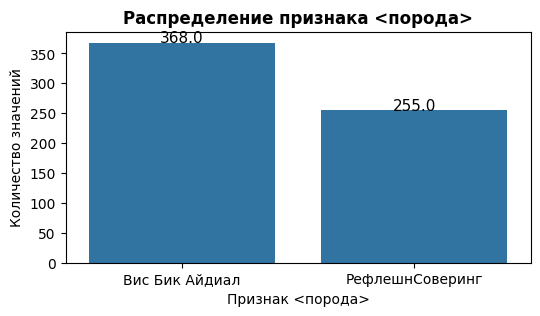

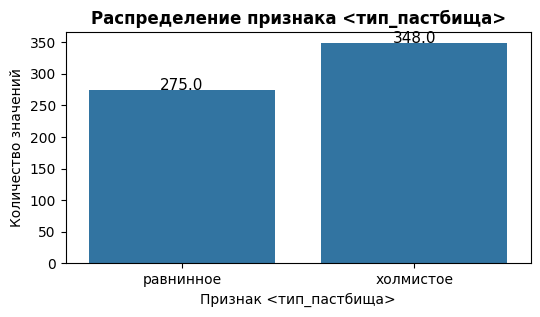

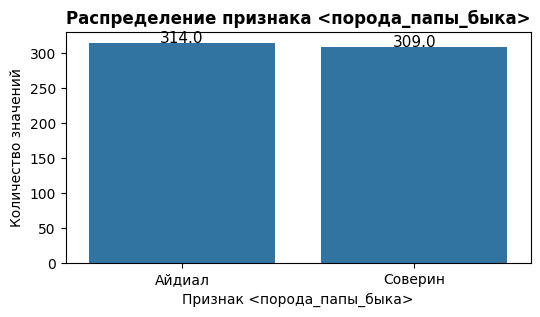

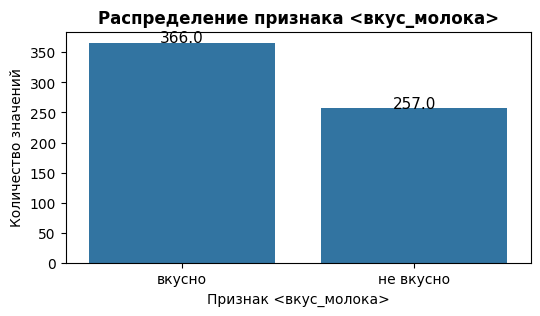

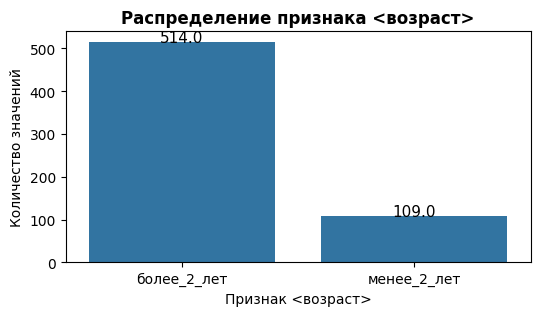

In [36]:
# функция для построения столбчатой диаграммы
def get_countplot(df, item):
    countplt, ax = plt.subplots()
    sns.countplot(x=item, data=df)
    plt.title(f"Распределение признака <{item}>", weight="bold")
    plt.xlabel(f"Признак <{item}>")
    plt.ylabel("Количество значений")
    for rect in ax.patches:
        (
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                rect.get_height(),
                rect.get_height(),
                horizontalalignment="center",
                fontsize=11,
            )
        )
    plt.show()


# построение столбчатой диаграммы
set_plot(clear_df, main_categ_lst, get_countplot)

#### Построение графиков для признаков датасета **cow_df**

Для количественных признаков датасета построим гистограммы

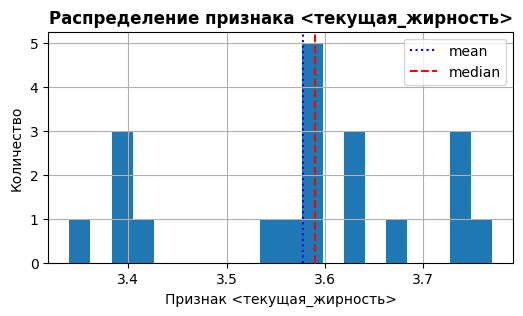

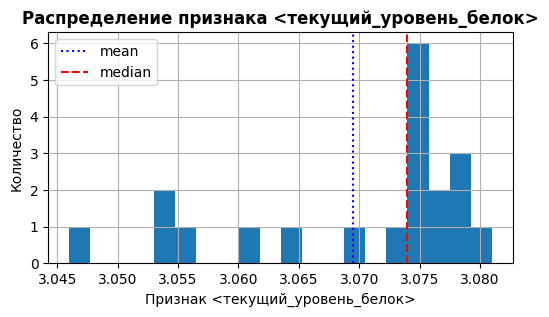

In [34]:
# построение гистограммы
set_plot(cow_df, cow_num_lst, get_hist)

Для категориальных признаков датасета построим столбчатые диграммы

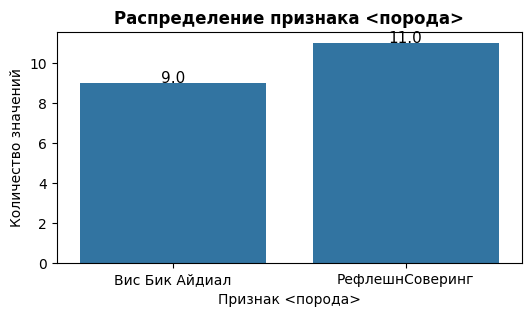

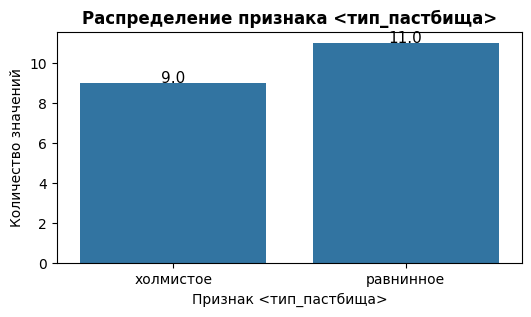

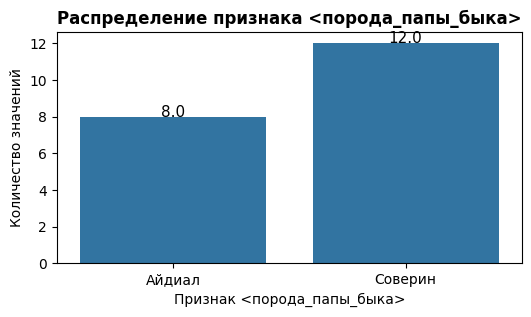

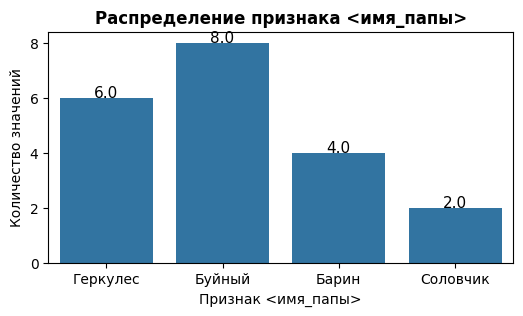

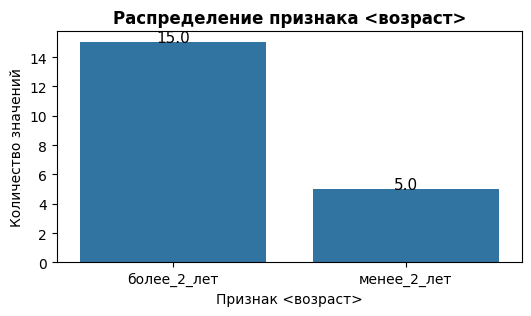

In [37]:
# построение столбчатой диаграммы
set_plot(cow_df, cow_categ_lst, get_countplot)

**Вывод:**
1. Для проведения статистического анализа признаков датасетов **main_df** и **cow_df**\
   была выведена описательная статистика и построены диаграммы размаха.
2. Также были построены гистограммы для количественных признаков,\
   и столбчатые диаграммы для категориальных признаков.
3. В датасете **main_df** были выявлены аномалии:
    - по признаку `'удой_кг'` - 1 выброс, который сильно искажает данные.
    - по признаку `'жирность'` - много выбросов ниже края статистически значимой выборки.
    - по признаку `'белок'` - 3 выброса.
4. В датасете были удалены выбросы по признакам `'удой_кг'` и `'белок'`
5. Количество удаленных данных в датасете **main_df** составляет 1,74 % от первоначального размера датасета.
6. В датасете **cow_df** аномалии не выявлены.
7. Для дальнейшей работы с датасетом выбран очищенный от выбросов датасет **clear_df**
8. Для всех входных признаков датасета **clear_df** на гистограммах видно,\
   что нормальное распределение присутствует только по признаку `'белок'`\
   Распределение признаков `'жирность'`, `'сырой_протеин_г'` и `'эке'` - мультимодальное со смещением.\
   У признака `'спо'` - на графике видны столбцы, объединённые в кластеры.

<a id='4'></a>
## Корреляционный анализ признаков в датафрейме *main_df*

### Изучение взаимосвязи между признаками: коэффициенты корреляции

Построим матрицу корреляции Фи, которая работает как с количественными, так и с категориальными признаками.

In [38]:
# построение матрицы
clear_df.drop("id", axis=1).phik_matrix(interval_cols=[*main_num_lst]).round(
    3
).style.background_gradient(cmap="coolwarm")

,удой_кг,эке,сырой_протеин_г,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
удой_кг,1.000000,0.720000,0.466000,0.661000,0.163000,0.275000,0.519000,0.708000,0.233000,0.173000,0.998000
эке,0.720000,1.000000,0.452000,0.592000,0.115000,0.103000,0.173000,0.718000,0.000000,0.273000,0.772000
сырой_протеин_г,0.466000,0.452000,1.000000,0.388000,0.085000,0.085000,0.000000,0.404000,0.226000,0.173000,0.348000
спо,0.661000,0.592000,0.388000,1.000000,0.052000,0.145000,0.427000,0.643000,0.000000,0.573000,0.749000
порода,0.163000,0.115000,0.085000,0.052000,1.000000,0.207000,0.094000,0.223000,0.375000,0.000000,0.053000
тип_пастбища,0.275000,0.103000,0.085000,0.145000,0.207000,1.000000,0.000000,0.000000,0.149000,0.269000,0.124000
порода_папы_быка,0.519000,0.173000,0.000000,0.427000,0.094000,0.000000,1.000000,0.000000,0.079000,0.000000,0.351000
жирность,0.708000,0.718000,0.404000,0.643000,0.223000,0.000000,0.000000,1.000000,0.000000,0.201000,0.683000
белок,0.233000,0.000000,0.226000,0.000000,0.375000,0.149000,0.079000,0.000000,1.000000,0.107000,0.000000
вкус_молока,0.173000,0.273000,0.173000,0.573000,0.000000,0.269000,0.000000,0.201000,0.107000,1.000000,0.156000


### Диаграмма рассеяния для признака <удой_кг> и количественных признаков с учётом категориальных

Построим диаграммы рассеяния

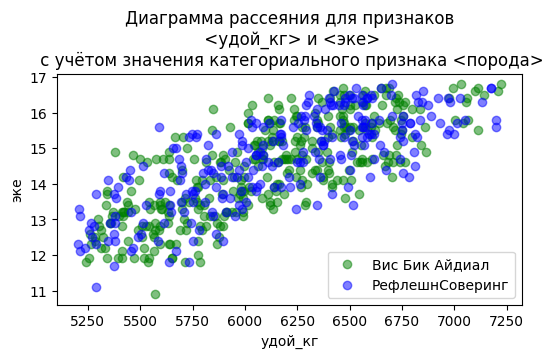

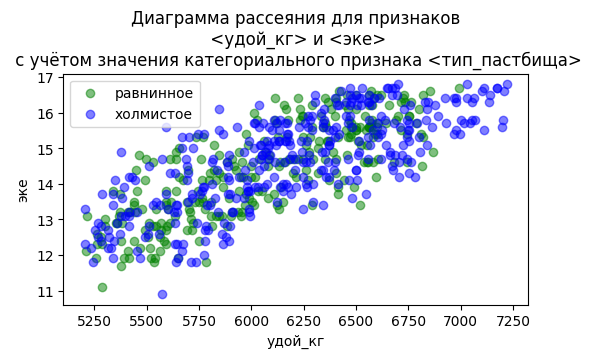

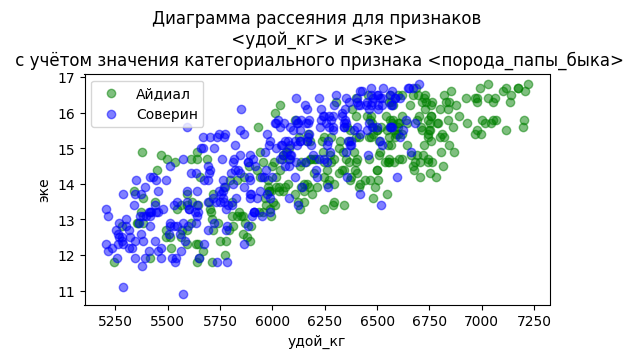

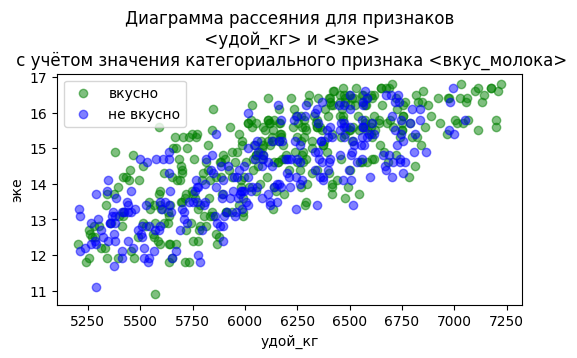

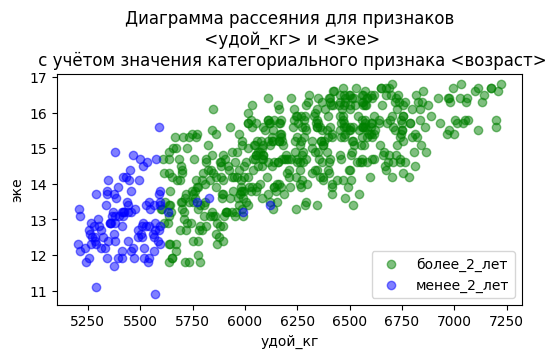

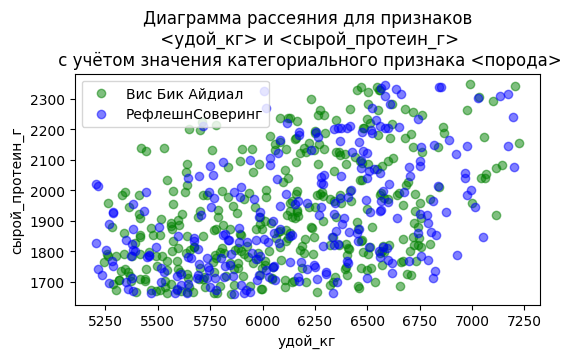

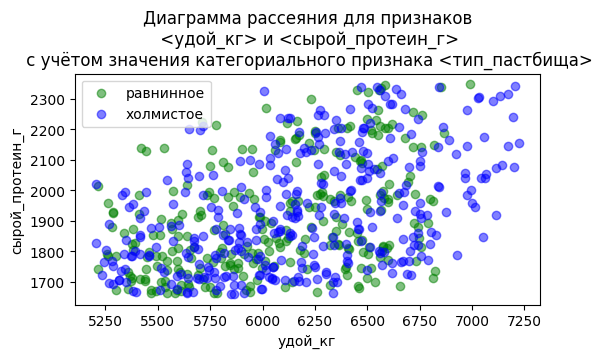

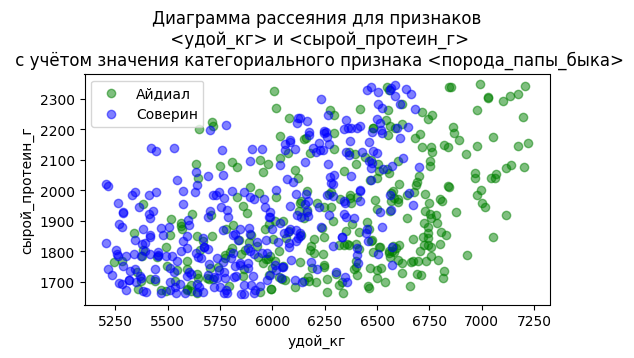

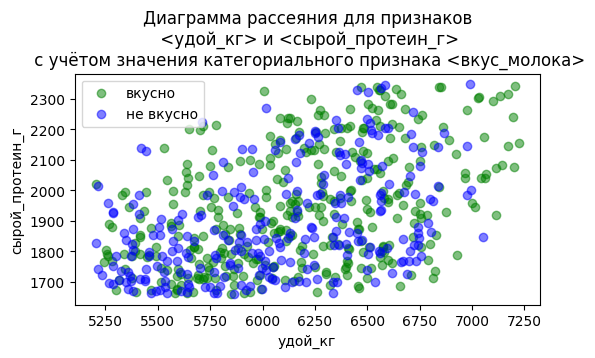

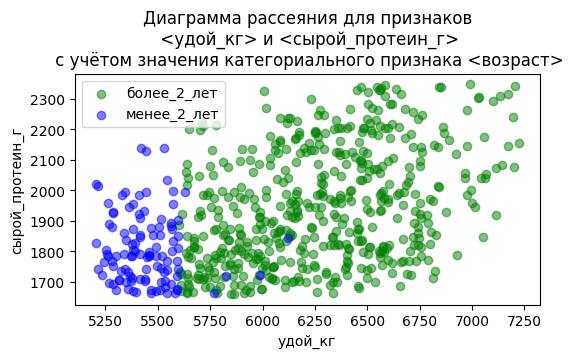

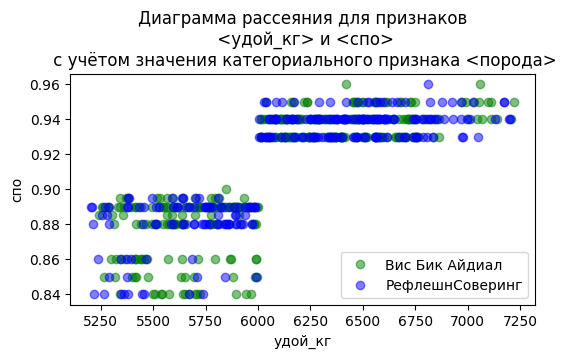

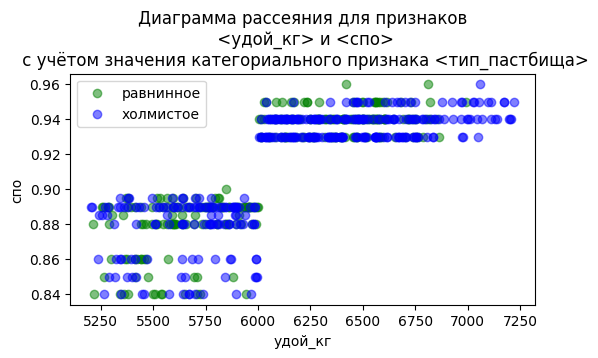

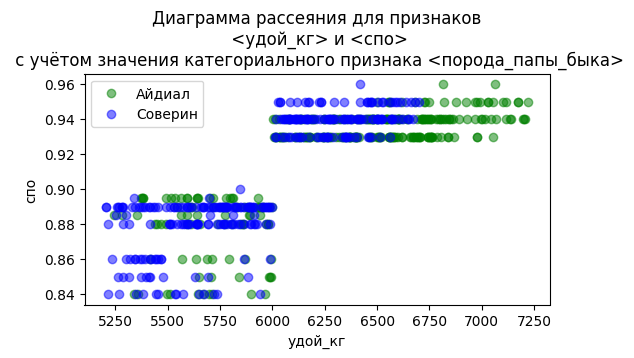

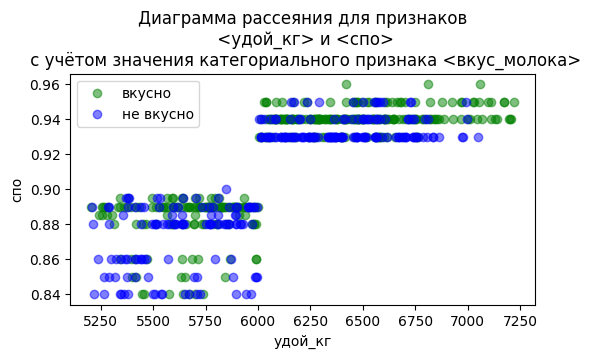

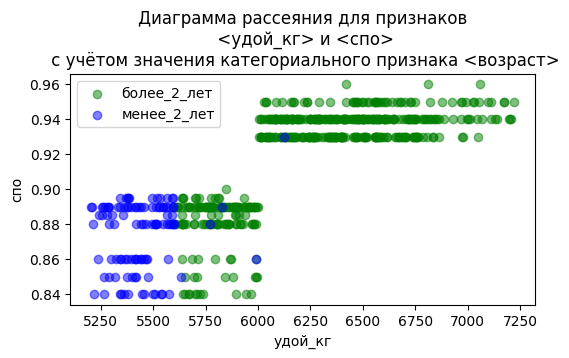

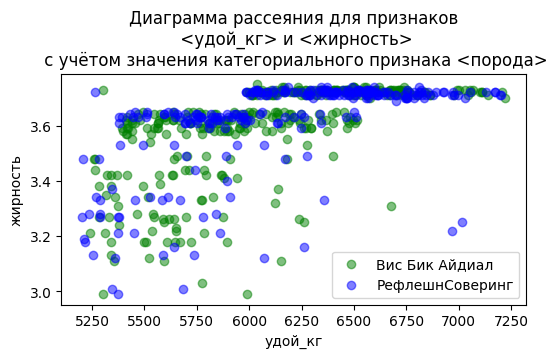

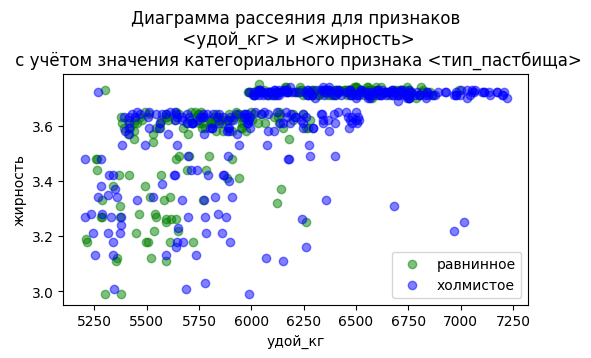

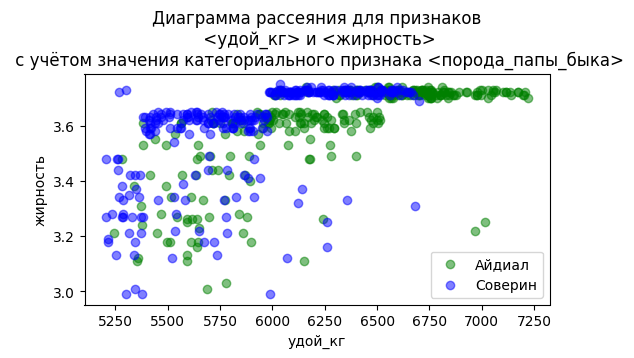

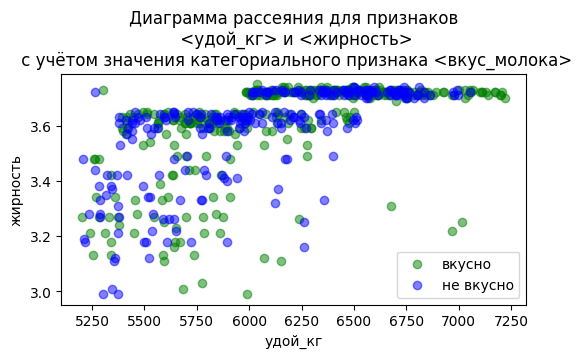

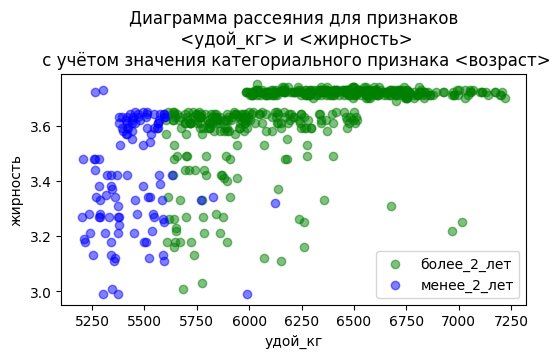

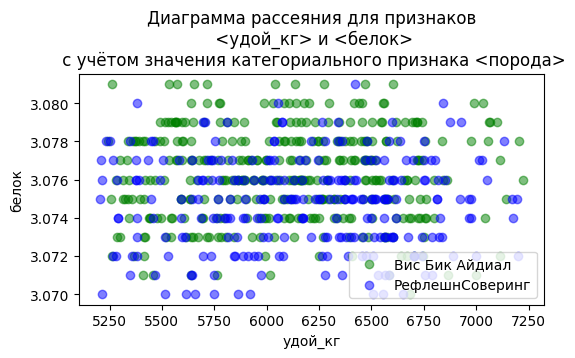

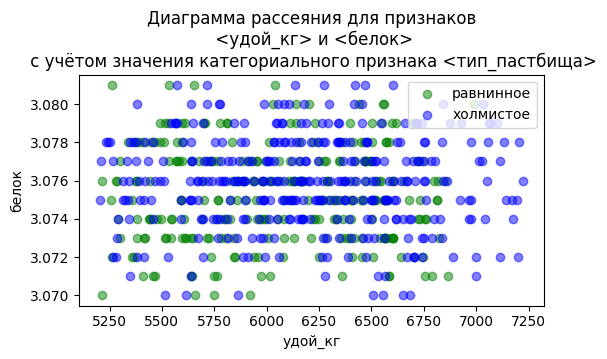

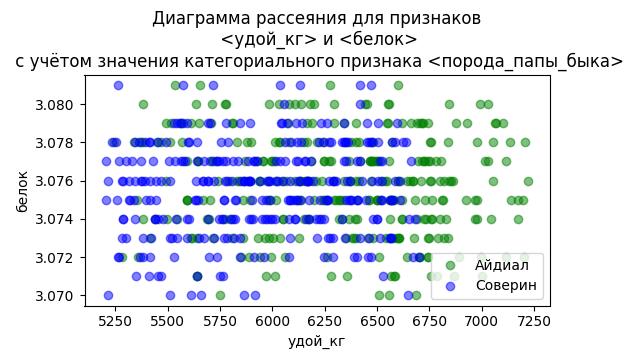

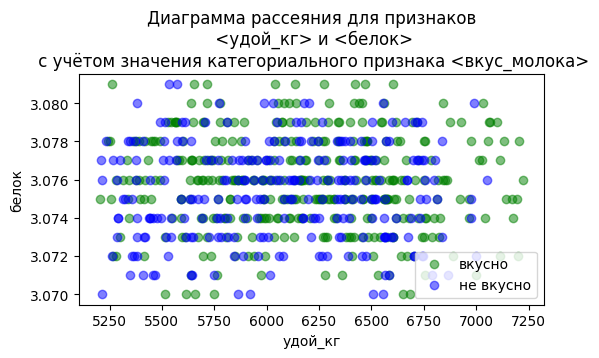

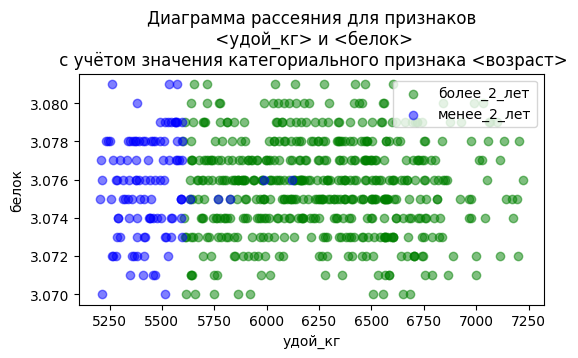

In [39]:
# функция для построения диаграммы рассеяния
def get_scatterplot():
    main_num_lst.remove("удой_кг")
    for i in main_num_lst:
        for j in main_categ_lst:
            keys = clear_df[j].unique()
            values = ["green", "blue"]
            colors = {key: value for key, value in zip(keys, values)}
            fig, ax = plt.subplots()
            for item, group in clear_df.groupby(j):
                ax.scatter(
                    x=group["удой_кг"],
                    y=group[i],
                    c=colors[item],
                    alpha=0.5,
                    label=item,
                )
            plt.title(
                f"Диаграмма рассеяния для признаков\n <удой_кг> и <{i}>\n с учётом значения категориального признака <{j}>"
            )
            plt.xlabel("удой_кг")
            plt.ylabel(i)
            ax.legend()
            plt.show()


# построение диаграммы
get_scatterplot()

**Вывод:**
1. Согласно шкале Чеддока между целевым признаком `'удой_кг'` и входными признаками выявлена линейная связь.\
   Теснота связи по корреляции Фи:
    - с входным признаком `'возраст'` - весьма высокая
    - с входным признаком `'жирность'` - высокая
    - с входным признаком `'эке'` - высокая
    - с входным признаком `'спо'` - заметная
    - с входным признаком `'порода_папы_быка'` - заметная
    - с входным признаком `'сырой_протеин_г'` - умеренная
    - с входным признаком `'порода'` - слабая
    - с входным признаком `'тип_пастбица'` - слабая
    - с входным признаком `'белок'` - слабая
2. Мультиколлинеарность между входными признаками согласно корреляции Фи отсутствует.
3. На диаграммах рассеяния между целевым признаком `'удой_кг'`:
    - и входным признаком `'эке'` заметна линейная связь
    - и входным признаком `'сырой_протеин_г'` заметна слабая линейная связь
    - и входным признаком `'спо'` заметна тенденция к кластеризации
    - и входным признаком `'жирность'` линейная связь отсутствует
    - и входным признаком `'белок'` линейная связь отсутствует

<a id='5'></a>
## Задача регрессии

### Первая модель LinearRegression

#### Подготовка данных датасета

##### Отбор признаков для модели линейной регрессии

In [40]:
# сохранение входных признаков в переменную X
X1 = clear_df.drop(["удой_кг", "вкус_молока", "id", "белок", "жирность"], axis=1)
# сохранение целевого признака в переменную y
y1 = clear_df["удой_кг"]
# выделение категориальных признаков в список
cat_col_names1 = ["порода_папы_быка", "возраст", "тип_пастбища", "порода"]
# выделение количественных признаков в список
num_col_names1 = ["эке", "сырой_протеин_г", "спо"]

##### Разбиение датасета на тренировочную и тестовую выборки

In [41]:
# разделение на тренировочную и тестовую выборки
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1, random_state=RANDOM_STATE
)

##### Кодирование категориальных признаков с помощью OneHotEncoder

In [46]:
# инициализация метода кодирования
encoder = OneHotEncoder(drop="first", sparse_output=False)

# обучение и кодирование тренировочной выборки
X1_train_ohe = encoder.fit_transform(X1_train[cat_col_names1])

# преобразование категориальных признаков в тестовой выборке
X1_test_ohe = encoder.transform(X1_test[cat_col_names1])

# получение списка новых столбцов
encoder_col_names1 = encoder.get_feature_names_out()

##### Масштабирование количественных признаков с помощью StandartScaler

In [47]:
# инициализация метода масштабирования
scaler = StandardScaler()

# обучение и масштабирование тренировочной выборки
X1_train_scaled = scaler.fit_transform(X1_train[num_col_names1])

# преобразование количественных признаков в тестовой выборке
X1_test_scaled = scaler.transform(X1_test[num_col_names1])

##### Создание тренировочного и тестового датафремов

In [48]:
# создание датафрейма из закодированных данных тренировочной выборки
X1_train_ohe = pd.DataFrame(X1_train_ohe, columns=encoder_col_names1)
# создание датафрейма из закодированных данных тестовой выборки
X1_test_ohe = pd.DataFrame(X1_test_ohe, columns=encoder_col_names1)
# создание датафрейма из мас1штабированных данных тренировочной выборки
X1_train_scaled = pd.DataFrame(X1_train_scaled, columns=num_col_names1)
# создание датафрейма из масштабированных данных тестовой выборки
X1_test_scaled = pd.DataFrame(X1_test_scaled, columns=num_col_names1)
# объединение данных в тренировочный датасет
X1_train = pd.concat([X1_train_ohe, X1_train_scaled], axis=1)
# объединение данных в тестовый датасет
X1_test = pd.concat([X1_test_ohe, X1_test_scaled], axis=1)

In [49]:
# проверка признаков датасета
X1_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467 entries, 0 to 466
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   порода_папы_быка_Соверин  467 non-null    float64
 1   возраст_менее_2_лет       467 non-null    float64
 2   тип_пастбища_холмистое    467 non-null    float64
 3   порода_РефлешнСоверинг    467 non-null    float64
 4   эке                       467 non-null    float64
 5   сырой_протеин_г           467 non-null    float64
 6   спо                       467 non-null    float64
dtypes: float64(7)
memory usage: 25.7 KB


#### Модель LinearRegression

##### Обучение модели LinearRegression

In [50]:
# инициализация модели
model_lr1 = LinearRegression()

# обучение модели на тренировочных данных
model_lr1.fit(X1_train, y1_train)

# получение предсказания модели на тестовых данных
predictions1 = model_lr1.predict(X1_test)

##### Оценка качества модели на тестовой выборке

In [51]:
# расчёт коэффициента детерминации
r2_1 = r2_score(y1_test, predictions1)
print(f"R2 LinearRegression {r2_1:.3f}")

R2 LinearRegression 0.783


#### Анализ остатков

In [52]:
# рассчёт остатков
residuals1 = y1_test - predictions1

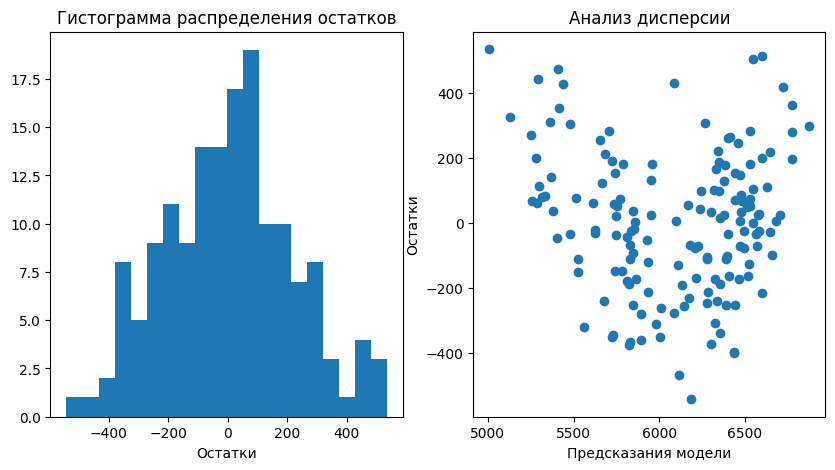

In [53]:
# построение гистограммы распределения остатков и диаграммы рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].hist(residuals1, bins=20)
axes[0].set_title("Гистограмма распределения остатков")
axes[0].set_xlabel("Остатки")

axes[1].scatter(x=predictions1, y=residuals1)
axes[1].set_xlabel("Предсказания модели")
axes[1].set_ylabel("Остатки")
axes[1].set_title("Анализ дисперсии")
plt.show()

**Вывод:**
1. Качество обученной модели LinearRegression по коэффициенту детерминации составляет 0,783
2. Гистограмма показывает мультимодальное распределение остатков модели, но в целом распределение стремится к нормальному.
3. Диаграмма рассеяния показывает некоторую "дугу" - чередование низкой и высокой дисперсии остатков.
4. Качество обученной модели недостаточно. Необходимо выявить данные в датасете, которые можно трансформировать,\
   чтобы изменить взаимосвязь входных признаков с целевым.

### Вторая модель LinearRegression

#### Подготовка данных с учётом связи входных признаков с целевым

##### Преобразование признака <спо> в категориальный бинарный признак

In [54]:
# преобразование признака в бинарный
clear_df["спо_кат"] = clear_df["спо"].apply(lambda x: "выше" if x > 0.91 else "ниже")

##### Создание нового признака <эке_в_квадрате>

In [55]:
# создание нового признака
clear_df["эке_в_квадрате"] = clear_df["эке"] ** 2

##### Отбор признаков для модели линейной регрессии

In [56]:
# сохранение входных признаков в переменную X
X2 = clear_df.drop(
    ["удой_кг", "вкус_молока", "id", "эке", "белок", "спо", "жирность"],
    axis=1,
)
# сохранение целевого признака в переменную y
y2 = clear_df["удой_кг"]
# выделение категориальных признаков в список
cat_col_names2 = ["порода_папы_быка", "возраст", "спо_кат", "порода", "тип_пастбища"]
# выделение количественных признаков в список
num_col_names2 = ["сырой_протеин_г", "эке_в_квадрате"]

##### Разбиение датасета на тренировочную и тестовую выборки

In [57]:
# разделение на тренировочную и тестовую выборки
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, random_state=RANDOM_STATE
)

##### Кодирование категориальных признаков с помощью OneHotEncoder

In [58]:
# обучение и кодирование тренировочной выборки
X2_train_ohe = encoder.fit_transform(X2_train[cat_col_names2])

# преобразование категориальных признаков в тестовой выборке
X2_test_ohe = encoder.transform(X2_test[cat_col_names2])

# получение списка новых столбцов
encoder_col_names2 = encoder.get_feature_names_out()

##### Масштабирование количественных признаков с помощью StandartScaler

In [59]:
# обучение и масштабирование тренировочной выборки
X2_train_scaled = scaler.fit_transform(X2_train[num_col_names2])

# преобразование количественных признаков в тестовой выборке
X2_test_scaled = scaler.transform(X2_test[num_col_names2])

##### Создание тренировочного и тестового датафремов

In [60]:
# создание датафрейма из закодированных данных тренировочной выборки
X2_train_ohe = pd.DataFrame(X2_train_ohe, columns=encoder_col_names2)
# создание датафрейма из закодированных данных тестовой выборки
X2_test_ohe = pd.DataFrame(X2_test_ohe, columns=encoder_col_names2)
# создание датафрейма из мас1штабированных данных тренировочной выборки
X2_train_scaled = pd.DataFrame(X2_train_scaled, columns=num_col_names2)
# создание датафрейма из масштабированных данных тестовой выборки
X2_test_scaled = pd.DataFrame(X2_test_scaled, columns=num_col_names2)
# объединение данных в тренировочный датасет
X2_train = pd.concat([X2_train_ohe, X2_train_scaled], axis=1)
# объединение данных в тестовый датасет
X2_test = pd.concat([X2_test_ohe, X2_test_scaled], axis=1)

In [61]:
# проверка признаков датасета
X2_train.head()

,порода_папы_быка_Соверин,возраст_менее_2_лет,спо_кат_ниже,порода_РефлешнСоверинг,тип_пастбища_холмистое,сырой_протеин_г,эке_в_квадрате
0,1.0,0.0,0.0,0.0,0.0,0.206082,1.626057
1,0.0,0.0,0.0,0.0,0.0,-0.185338,1.449208
2,0.0,0.0,1.0,0.0,0.0,0.265882,-0.430475
3,0.0,0.0,1.0,1.0,0.0,-0.832267,-0.946283
4,0.0,0.0,1.0,0.0,0.0,-1.397651,0.032546


#### Модель LinearRegression

##### Обучение модели LinearRegressor

In [62]:
# инициализация модели
model_lr2 = LinearRegression()

# обучение модели на тренировочных данных
model_lr2.fit(X2_train, y2_train)

# получение предсказания модели на тестовых данных
predictions2 = model_lr2.predict(X2_test)

##### Оценка качества модели на тестовой выборке

In [63]:
# расчёт коэффициента детерминации
r2_2 = r2_score(y2_test, predictions2)
print(f"R2 LinearRegression {r2_2:.3f}")

R2 LinearRegression 0.835


#### Анализ остатков

In [64]:
# рассчёт остатков
residuals2 = y2_test - predictions2

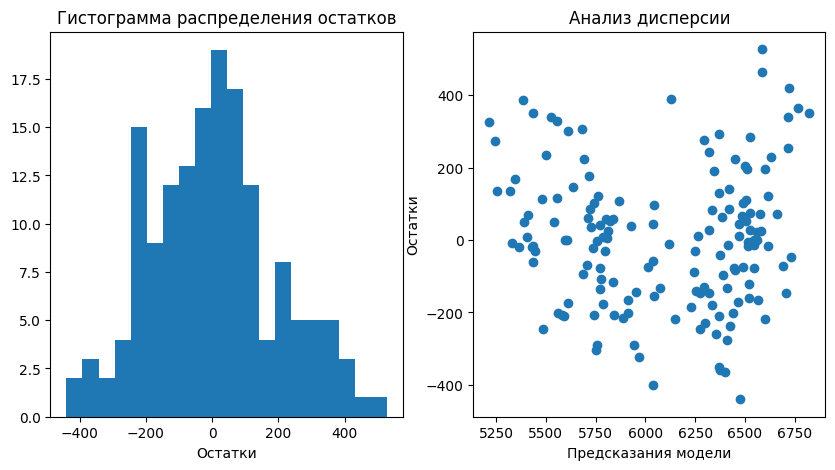

In [65]:
# построение гистограммы распределения остатков и диаграммы рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].hist(residuals2, bins=20)
axes[0].set_title("Гистограмма распределения остатков")
axes[0].set_xlabel("Остатки")

axes[1].scatter(x=predictions2, y=residuals2)
axes[1].set_xlabel("Предсказания модели")
axes[1].set_ylabel("Остатки")
axes[1].set_title("Анализ дисперсии")
plt.show()

**Вывод:**
1. Качество обученной модели LinearRegression по коэффициенту детерминации составляет 0,835,\
   что немного лучше, чем у первой модели.
3. Гистограмма показывает мультимодальное распределение остатков модели.
4. Диаграмма рассеяния показывает некоторую "дугу" - чередование низкой и высокой дисперсии остатков.
5. Качество обученной модели недостаточно. Необходимо выявить данные в датасете, которые можно трансформировать,\
   чтобы изменить взаимосвязь входных признаков с целевым.

### Третья модель LinearRegression

#### Подготовка данных с добавлением нового признака

##### Добавление признака <имя_папы> из датафрейма dad_df

In [66]:
# объединение датафреймов
clear_df = clear_df.merge(dad_df, on="id", how="left")

##### Отбор признаков для модели линейной регрессии

In [67]:
# сохранение входных признаков в переменную X
X3 = clear_df.drop(
    ["удой_кг", "вкус_молока", "id", "эке", "белок", "спо", "жирность"],
    axis=1,
)
# сохранение целевого признака в переменную y
y3 = clear_df["удой_кг"]
# выделение категориальных признаков в список
cat_col_names3 = [
    "порода_папы_быка",
    "возраст",
    "спо_кат",
    "имя_папы",
    "порода",
    "тип_пастбища",
]
# выделение количественных признаков в список
num_col_names3 = ["сырой_протеин_г", "эке_в_квадрате"]

##### Разбиение датасета на тренировочную и тестовую выборки

In [68]:
# разделение на тренировочную и тестовую выборки
X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, y3, random_state=RANDOM_STATE
)

##### Кодирование категориальных признаков с помощью OneHotEncoder

In [69]:
# обучение и кодирование тренировочной выборки
X3_train_ohe = encoder.fit_transform(X3_train[cat_col_names3])

# преобразование категориальных признаков в тестовой выборке
X3_test_ohe = encoder.transform(X3_test[cat_col_names3])

# получение списка новых столбцов
encoder_col_names3 = encoder.get_feature_names_out()

##### Масштабирование количественных признаков с помощью StandartScaler

In [70]:
# обучение и масштабирование тренировочной выборки
X3_train_scaled = scaler.fit_transform(X3_train[num_col_names3])

# преобразование количественных признаков в тестовой выборке
X3_test_scaled = scaler.transform(X3_test[num_col_names3])

##### Создание тренировочного и тестового датафремов

In [71]:
# создание датафрейма из закодированных данных тренировочной выборки
X3_train_ohe = pd.DataFrame(X3_train_ohe, columns=encoder_col_names3)
# создание датафрейма из закодированных данных тестовой выборки
X3_test_ohe = pd.DataFrame(X3_test_ohe, columns=encoder_col_names3)
# создание датафрейма из мас1штабированных данных тренировочной выборки
X3_train_scaled = pd.DataFrame(X3_train_scaled, columns=num_col_names3)
# создание датафрейма из масштабированных данных тестовой выборки
X3_test_scaled = pd.DataFrame(X3_test_scaled, columns=num_col_names3)
# объединение данных в тренировочный датасет
X3_train = pd.concat([X3_train_ohe, X3_train_scaled], axis=1)
# объединение данных в тестовый датасет
X3_test = pd.concat([X3_test_ohe, X3_test_scaled], axis=1)

In [72]:
# проверка признаков датасета
X3_train.head()

,порода_папы_быка_Соверин,возраст_менее_2_лет,спо_кат_ниже,имя_папы_Буйный,имя_папы_Геркулес,имя_папы_Соловчик,порода_РефлешнСоверинг,тип_пастбища_холмистое,сырой_протеин_г,эке_в_квадрате
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.206082,1.626057
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.185338,1.449208
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.265882,-0.430475
3,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,-0.832267,-0.946283
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.397651,0.032546


#### Модель LinearRegression

##### Обучение модели LinearRegressor

In [73]:
# инициализация модели
model_lr3 = LinearRegression()

# обучение модели на тренировочных данных
model_lr3.fit(X3_train, y3_train)

# получение предсказания модели на тестовых данных
predictions3 = model_lr3.predict(X3_test)

##### Оценка качества модели на тестовой выборке

In [74]:
# расчёт коэффициента детерминации
r2_3 = r2_score(y3_test, predictions3)
print(f"R2 LinearRegression {r2_3:.3f}")

R2 LinearRegression 0.841


#### Анализ остатков

In [75]:
# рассчёт остатков
residuals3 = y3_test - predictions3

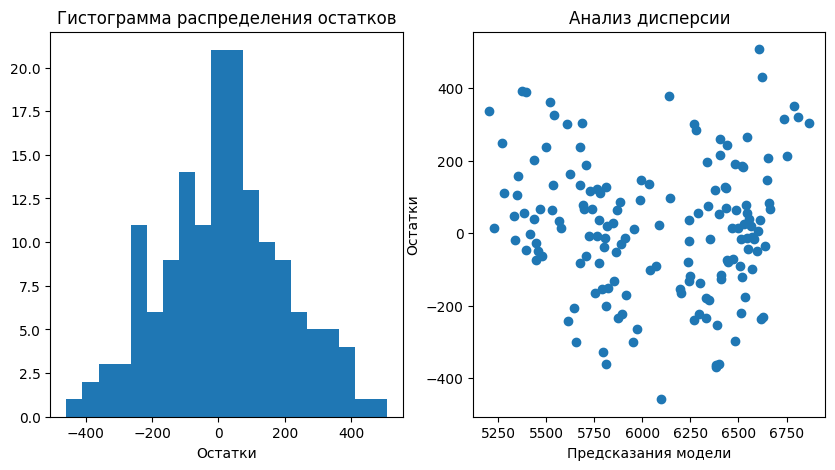

In [76]:
# построение гистограммы распределения остатков и диаграммы рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].hist(residuals3, bins=20)
axes[0].set_title("Гистограмма распределения остатков")
axes[0].set_xlabel("Остатки")

axes[1].scatter(x=predictions3, y=residuals3)
axes[1].set_xlabel("Предсказания модели")
axes[1].set_ylabel("Остатки")
axes[1].set_title("Анализ дисперсии")
plt.show()

**Вывод:**
1. Качество обученной модели LinearRegression по коэффициенту детерминации составляет 0,841,\
   что немного лучше, чем у предыдущих моделей.
3. Гистограмма показывает почти нормальное распределение остатков модели, но есть пики.
4. Диаграмма рассеяния показывает достаточно постоянную дисперсию остатков,\
   но присутствуют области с более низкой и высокой дисперсией остатков.
5. Качество обученной модели значительно улучшилось, но ещё недостаточно.\
   Можно выявить данные в датасете, которые можно трансформировать,\
   чтобы изменить взаимосвязь входных признаков с целевым.

### Сравнение качества моделей LinearRegression

Сравним качество моделей по коэффициентам детерминации

In [77]:
print(f"Коэффициент детерминации R2 первой модели LinearRegression - {r2_1:.3f}")
print(f"Коэффициент детерминации R2 второй модели LinearRegression - {r2_2:.3f}")
print(f"Коэффициент детерминации R2 третьей модели LinearRegression - {r2_3:.3f}")

Коэффициент детерминации R2 первой модели LinearRegression - 0.783
Коэффициент детерминации R2 второй модели LinearRegression - 0.835
Коэффициент детерминации R2 третьей модели LinearRegression - 0.841


Сравним качество моделей по остаткам

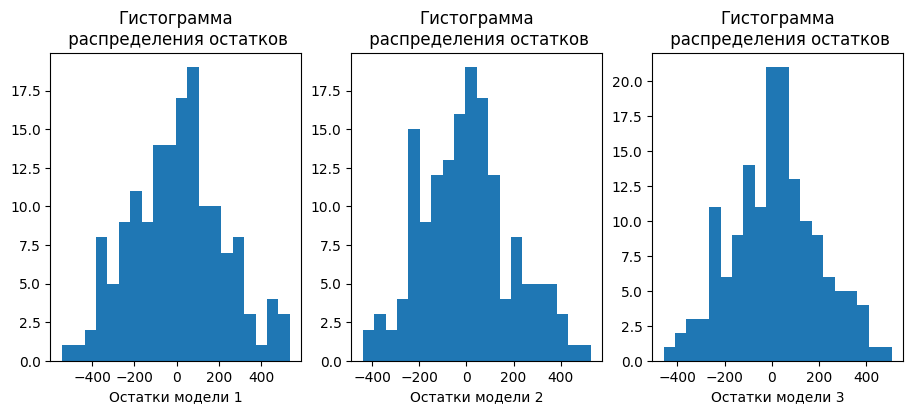

In [78]:
# построение гистограмм распределения остатков
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 4))
i = 0
res = [residuals1, residuals2, residuals3]
for residuals in res:
    axes[i].hist(residuals, bins=20)
    axes[i].set_title("Гистограмма\n распределения остатков")
    axes[i].set_xlabel(f"Остатки модели {i+1}")
    i += 1

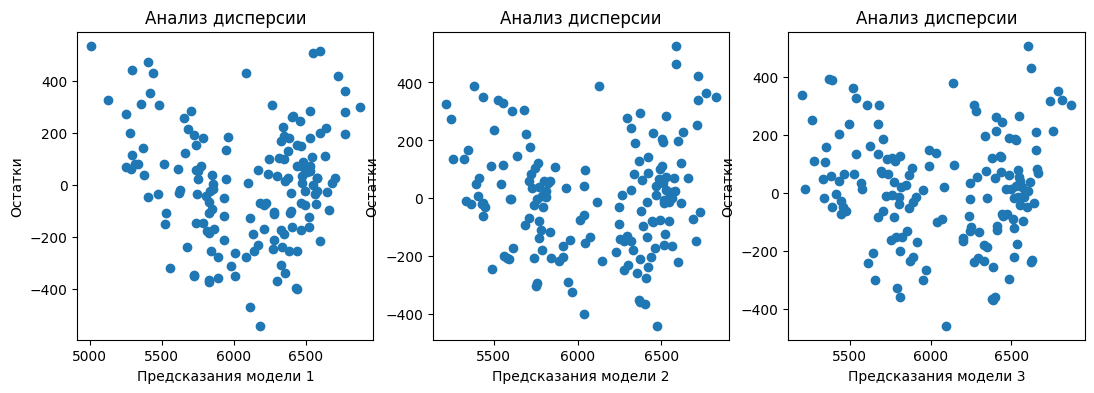

In [79]:
# построение диаграмм рассеяния
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 4))
pred = [predictions1, predictions2, predictions3]
for i in range(len(res)):
    axes[i].scatter(x=pred[i], y=res[i])
    axes[i].set_xlabel(f"Предсказания модели {i+1}")
    axes[i].set_ylabel("Остатки")
    axes[i].set_title("Анализ дисперсии")

**Вывод:**
1. Качество 3-ей модели немного лучше, чем первой и второй.
2. Гистограмма распределения остатков третьей модели имеет более похожее на нормальное распределение.
3. Дисперсия остатков третьей модели немного лучше предыдущих.

### Оценка качества моделей по метрикам: MSE, MAE, RMSE

Вычислим метрики для всех моделей линейной регрессии

In [82]:
# вычисление MSE
mse1 = mean_squared_error(y1_test, predictions1)
mse2 = mean_squared_error(y2_test, predictions2)
mse3 = mean_squared_error(y3_test, predictions3)
# вычисление RMSE
rmse1 = root_mean_squared_error(y1_test, predictions1)
rmse2 = root_mean_squared_error(y2_test, predictions2)
rmse3 = root_mean_squared_error(y3_test, predictions3)
# вычисление MAE
mae1 = mean_absolute_error(y1_test, predictions1)
mae2 = mean_absolute_error(y2_test, predictions2)
mae3 = mean_absolute_error(y3_test, predictions3)

Выведем значения метрик

In [83]:
print(f"MSE 1-ой модели LinearRegression - {mse1:.3f}")
print(f"MSE 2-ой модели LinearRegression - {mse2:.3f}")
print(f"MSE 3-ей модели LinearRegression - {mse3:.3f}")
print("")
print(f"RMSE 1-ой модели LinearRegression - {rmse1:.3f}")
print(f"RMSE 2-ой модели LinearRegression - {rmse2:.3f}")
print(f"RMSE 3-ей модели LinearRegression - {rmse3:.3f}")
print("")
print(f"MAE 1-ой модели LinearRegression - {mae1:.0f}")
print(f"MAE 2-ой модели LinearRegression - {mae2:.0f}")
print(f"MAE 3-ей модели LinearRegression - {mae3:.0f}")

MSE 1-ой модели LinearRegression - 47499.999
MSE 2-ой модели LinearRegression - 36207.490
MSE 3-ей модели LinearRegression - 34749.382

RMSE 1-ой модели LinearRegression - 217.945
RMSE 2-ой модели LinearRegression - 190.283
RMSE 3-ей модели LinearRegression - 186.412

MAE 1-ой модели LinearRegression - 174
MAE 2-ой модели LinearRegression - 150
MAE 3-ей модели LinearRegression - 147


Лучшая модель по метрикам - третья модель LinearRegression.

Рассчитаем ошибки модели на тренировочных данных

In [84]:
# вычисление ошибок модели на тренировочной выборке
predictions_train = model_lr3.predict(X3_train)
residuals_train = y3_train - predictions_train

Вычислим доверительный интервал прогноза третьей модели в 95 %

Для этого вычислим квантили ошибки модели на тренировочных данных

In [85]:
# вычисление доверительного интервала
quantiles = (0.025, 0.975)

lower_quantile = np.quantile(residuals_train, quantiles[0])
upper_quantile = np.quantile(residuals_train, quantiles[1])

print(
    f"Доверительный интервал прогноза: [{lower_quantile.round(3)}, {upper_quantile.round(3)}]"
)

Доверительный интервал прогноза: [-359.281, 374.088]


**Вывод:**
1. Лучшая модель LinearRegression - третья.
2. Метрики третьей модели LinearRegression:
    - MSE  - 34749.382
    - RMSE - 186.412
    - MAE  - 147
3. Доверительный 95% интервал прогноза третьей модели LinearRegression - [-359,281; 374,088]

### Прогноз удоя коров

#### Добавление недостающих признаков

Добавим в датасет **cow_df** недостающие признаки `'эке'`, `'сырой_протеин'`, `'спо'`

In [86]:
# добавление новых признаков
cow_df["эке"] = clear_df["эке"].mean() * 1.05
cow_df["сырой_протеин_г"] = clear_df["сырой_протеин_г"].mean() * 1.05
cow_df["спо"] = clear_df["спо"].mean() * 1.05

In [87]:
# проверка добавления признаков
cow_df.head()

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность,текущий_уровень_белок,возраст,эке,сырой_протеин_г,спо
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276742,2019.77191,0.958947
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276742,2019.77191,0.958947
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276742,2019.77191,0.958947
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276742,2019.77191,0.958947
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276742,2019.77191,0.958947


#### Подготовка данных датасета

##### Преобразование признака <спо> в категориальный бинарный признак

In [88]:
# преобразование признака в бинарный
cow_df["спо_кат"] = cow_df["спо"].apply(lambda x: "выше" if x > 0.91 else "ниже")

##### Создание нового признака <эке_в_квадрате>

In [89]:
# создание нового признака
cow_df["эке_в_квадрате"] = cow_df["эке"] ** 2

In [90]:
# проверка признаков датасета
cow_df.head()

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность,текущий_уровень_белок,возраст,эке,сырой_протеин_г,спо,спо_кат,эке_в_квадрате
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276742,2019.77191,0.958947,выше,233.378833
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276742,2019.77191,0.958947,выше,233.378833
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276742,2019.77191,0.958947,выше,233.378833
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276742,2019.77191,0.958947,выше,233.378833
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276742,2019.77191,0.958947,выше,233.378833


##### Отбор признаков для модели линейной регрессии

In [91]:
# преобразование наименований столбцов
cow_df.rename(
    columns={"текущая_жирность": "жирность", "текущий_уровень_белок": "белок"},
    inplace=True,
)
# сохранение входных признаков в переменную X
X_cow1 = cow_df.drop(
    ["эке", "спо", "белок", "жирность"],
    axis=1,
)
# выделение категориальных признаков в список
cat_col_names_cow1 = [
    "порода_папы_быка",
    "возраст",
    "спо_кат",
    "имя_папы",
    "порода",
    "тип_пастбища",
]
# выделение количественных признаков в список
num_col_names_cow1 = ["сырой_протеин_г", "эке_в_квадрате"]

##### Кодирование категориальных признаков с помощью OneHotEncoder

In [93]:
# преобразование категориальных признаков
X_cow_ohe1 = encoder.transform(X_cow1[cat_col_names_cow1])

# получение списка новых столбцов
encoder_col_names_cow1 = encoder.get_feature_names_out()

##### Масштабирование количественных признаков с помощью StandartScaler

In [94]:
# преобразование количественных признаков
X_cow_scaled1 = scaler.transform(X_cow1[num_col_names_cow1])

##### Создание датасета для предсказания

In [95]:
# создание датафрейма из закодированных данных тренировочной выборки
X_cow_ohe1 = pd.DataFrame(X_cow_ohe1, columns=encoder_col_names_cow1)
# создание датафрейма из масштабированных данных тренировочной выборки
X_cow_scaled1 = pd.DataFrame(X_cow_scaled1, columns=num_col_names_cow1)
# объединение данных в датасет
X_cow1 = pd.concat([X_cow_ohe1, X_cow_scaled1], axis=1)

In [96]:
# проверка признаков датасета
X_cow1.head()

,порода_папы_быка_Соверин,возраст_менее_2_лет,спо_кат_ниже,имя_папы_Буйный,имя_папы_Геркулес,имя_папы_Соловчик,порода_РефлешнСоверинг,тип_пастбища_холмистое,сырой_протеин_г,эке_в_квадрате
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.498407,0.495804
1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.498407,0.495804
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.498407,0.495804
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.498407,0.495804
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.498407,0.495804


#### Модель LinearRegression

##### Получение предсказания модели LinearRegressor

In [97]:
# получение предсказания модели
predictions_cow1 = model_lr3.predict(X_cow1)
# вывод предсказаний
print(predictions_cow1.round(3))

[6609.254 6358.103 6283.593 6599.114 6544.62  6442.5   6609.254 6556.597
 6283.593 6400.62  6334.076 6640.995 6609.254 6102.464 6283.593 6599.114
 6334.076 6442.5   6556.597 6544.62 ]


**Вывод:**
1. Для решения задачи регрессии были созданы 3 модели линейной регрессии
2. Качество 3-ей модели немного лучше, чем первой и второй.
3. Метрики третьей модели LinearRegression:
    - MSE - 40186.205
    - RMSE - 200.465
    - MAE - 156
4. Третья модель линейной регрессии была использована для получения предсказания об удое коров из датасета **cow_df**

<a id='6'></a>
## Задача классификации

### Подготовка данных датасета

##### Отбор признаков для модели логистической регрессии

Изменим тип данных целевого признака `'вкус_молока'` на *category*

In [98]:
# перевод данных в бинарный признак
clear_df["вкус_молока"] = np.where(clear_df["вкус_молока"].str.contains("не"), 0, 1)
# изменение типа данных
clear_df["вкус_молока"] = clear_df["вкус_молока"].astype("category")

In [99]:
main_df

,id,удой_кг,эке,сырой_протеин_г,спо,порода,тип_пастбища,порода_папы_быка,жирность,белок,вкус_молока,возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет
...,...,...,...,...,...,...,...,...,...,...,...,...
624,625,6812,15.4,1964,0.940,РефлешнСоверинг,равнинное,Айдиал,3.74,3.075,не вкусно,более_2_лет
625,626,5513,12.9,1700,0.880,РефлешнСоверинг,равнинное,Соверин,3.64,3.073,вкусно,менее_2_лет
626,627,5970,14.4,1837,0.880,РефлешнСоверинг,холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
627,628,5746,13.8,1994,0.890,РефлешнСоверинг,равнинное,Соверин,3.64,3.077,вкусно,более_2_лет


In [100]:
# сохранение входных признаков в переменную X
X4 = clear_df.drop(
    ["id", "удой_кг", "вкус_молока", "спо_кат", "эке_в_квадрате"],
    axis=1,
)
# сохранение целевого признака в переменную y
y4 = clear_df["вкус_молока"]
# выделение категориальных признаков в список
cat_col_names4 = [
    "тип_пастбища",
    "возраст",
    "имя_папы",
    "порода",
    "порода_папы_быка",
]
# выделение количественных признаков в список
num_col_names4 = ["сырой_протеин_г", "жирность", "белок", "эке", "спо"]

##### Разбиение датасета на тренировочную и тестовую выборки

In [103]:
# разделение на тренировочную и тестовую выборки
X4_train, X4_test, y4_train, y4_test = train_test_split(
    X4, y4, random_state=RANDOM_STATE
)

##### Кодирование категориальных признаков с помощью OneHotEncoder

In [102]:
# обучение и кодирование тренировочной выборки
X4_train_ohe = encoder.fit_transform(X4_train[cat_col_names4])

# преобразование категориальных признаков в тестовой выборке
X4_test_ohe = encoder.transform(X4_test[cat_col_names4])

# получение списка новых столбцов
encoder_col_names4 = encoder.get_feature_names_out()

##### Масштабирование количественных признаков с помощью StandartScaler

In [104]:
# обучение и масштабирование тренировочной выборки
X4_train_scaled = scaler.fit_transform(X4_train[num_col_names4])

# преобразование количественных признаков в тестовой выборке
X4_test_scaled = scaler.transform(X4_test[num_col_names4])

##### Создание тренировочного и тестового датафремов

In [105]:
# создание датафрейма из закодированных данных тренировочной выборки
X4_train_ohe = pd.DataFrame(X4_train_ohe, columns=encoder_col_names4)
# создание датафрейма из закодированных данных тестовой выборки
X4_test_ohe = pd.DataFrame(X4_test_ohe, columns=encoder_col_names4)
# создание датафрейма из мас1штабированных данных тренировочной выборки
X4_train_scaled = pd.DataFrame(X4_train_scaled, columns=num_col_names4)
# создание датафрейма из масштабированных данных тестовой выборки
X4_test_scaled = pd.DataFrame(X4_test_scaled, columns=num_col_names4)
# объединение данных в тренировочный датасет
X4_train = pd.concat([X4_train_ohe, X4_train_scaled], axis=1)
# объединение данных в тестовый датас1ет
X4_test = pd.concat([X4_test_ohe, X4_test_scaled], axis=1)

In [106]:
# проверка входных признаков
X4_train.head()

,тип_пастбища_холмистое,возраст_менее_2_лет,имя_папы_Буйный,имя_папы_Геркулес,имя_папы_Соловчик,порода_РефлешнСоверинг,порода_папы_быка_Соверин,сырой_протеин_г,жирность,белок,эке,спо
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.206082,0.727262,0.550740,1.543027,1.426018
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.185338,0.665466,-0.656751,1.388625,0.795084
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.265882,-0.199680,0.953236,-0.386997,-0.782250
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.832267,0.109301,-1.864241,-0.927403,-1.097716
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.397651,-2.671524,1.355733,0.076209,-1.097716


### Модель LogisticRegression

##### Обучение модели LogisticRegressor

In [107]:
# инициализация модели
clf = LogisticRegression()

# обучение модели на тренировочных данных
clf.fit(X4_train, y4_train)

# получение предсказания модели на тестовых данных
y_pred = clf.predict(X4_test)

### Оценка качества модели на тестовой выборке

Рассчитаем и выведем метрики: ***accuracy***, ***precision*** и ***recall***

In [108]:
# расчёт метрик
accuracy = accuracy_score(y_pred, y4_test)
precision = precision_score(y_pred, y4_test)
recall = recall_score(y_pred, y4_test)
# вывод метрик качества
print(f"accuracy - {accuracy:.3f}")
print(f"precision - {precision:.3f}")
print(f"recall - {recall:.3f}")

accuracy - 0.603
precision - 0.759
recall - 0.617


Проверим модель на адекватность, используя DummyClassifier

In [110]:
# инициация dummy-модели
dummy_model = DummyClassifier(strategy="constant", constant=0)
# обучение dummy-модели
dummy_model.fit(X4_train, y4_train)
# расчёт accuracy dummy-модели
acc_dummy = accuracy_score(dummy_model.predict(X4_test), y4_test)
print(f"accuracy dummy-модели - {round(acc_dummy, 3)}")

accuracy dummy-модели - 0.442


Метрика accuracy dummy-модели составляет 0,442, что меньше, чем у модели LogisticRegression (0,603).\
Таким образом, построенная модель LogisticRegression имеет лучшую предсказательную способность.

Построим матрицу ошибок

Text(0.5, 3.722222222222216, 'Predicted')

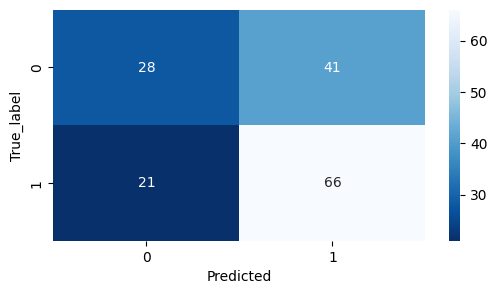

In [111]:
# построение матрицы ошибок
cm = confusion_matrix(y4_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues_r")
plt.ylabel("True_label")
plt.xlabel("Predicted")

### Анализ модели

Так как для заказчика главное - чтобы молоко точно было вкусным,\
то для модели важнее всего избегать ошибок первого рода:\
то есть не допускать предсказаний False Positive.

Для этого важнее точность, с которой модель присваивает объектам класс 1,\
то есть Positive, чем полнота присвоения всем объектам этого класса класса 1.\
Поэтому важнее метрика precision, чем recall.

Получим предсказания модели при разных порогах принадлежности к классам.\
Так как модель LogisticRegression по умолчанию использует порог 0,5,\
а с этим порогом precision модели только 0.759,\
получим предсказания модели для порогов от 0,6 до 0,9

In [112]:
# настройка пороговых значений
thresholds = [round(i, 2) for i in np.linspace(0.6, 0.9, num=10, endpoint=False)]

# получение предсказаний вероятностей
y_proba = clf.predict_proba(X4_test)[:, 1]

# создание датафрейма с предсказаниями
data = pd.DataFrame(zip(y4_test, y_proba), columns=["y_valid", "y_proba"]).sort_values(
    by="y_proba", ascending=False
)

# добавление столбцов с предсказаниями
columns = []
for i in thresholds:
    columns.append("y_pred_" + str(i))
    data["y_pred_" + str(i)] = data["y_proba"].apply(lambda x: 1 if x >= i else 0)

Исходя из получившегося датасета создадим таблицу со значениями метрик для каждого порога.

In [113]:
# добавление итоговой строки
data.loc["Число предсказанных объектов класса 1"] = data.sum()

# транспонирование таблицы
data_df = data.T

In [114]:
# объявление списка индексов
inds = data_df.columns.to_list()
inds.remove("Число предсказанных объектов класса 1")

# создание новых столбцов таблицы
data_df["TruePositive"] = 0
data_df["FalsePositive"] = 0
data_df["FalseNegative"] = 0
data_df["recall"] = 0
data_df["precision"] = 0

# заполнение новых столбцов таблицы
for col in columns:
    tp = 0
    fp = 0
    fn = 0
    for ind in inds:
        if data_df.loc[col, ind] == 1 and data_df.loc["y_valid", ind] == 1:
            tp += 1
        elif data_df.loc[col, ind] == 1 and data_df.loc["y_valid", ind] == 0:
            fp += 1
        elif data_df.loc[col, ind] == 0 and data_df.loc["y_valid", ind] == 1:
            fn += 1
    data_df.loc[col, "TruePositive"] = round(tp, 3)
    data_df.loc[col, "FalsePositive"] = round(fp, 3)
    data_df.loc[col, "FalseNegative"] = round(fn, 3)
    try:
        data_df.loc[col, "recall"] = round(tp / (tp + fn), 3)
    except ZeroDivisionError:
        pass
    try:
        data_df.loc[col, "precision"] = round(tp / (tp + fp), 3)
    except ZeroDivisionError:
        pass

In [115]:
# вывод значений
data_df.loc["y_pred_0.6":, "Число предсказанных объектов класса 1":"precision"]

,Число предсказанных объектов класса 1,TruePositive,FalsePositive,FalseNegative,recall,precision
y_pred_0.6,74.0,54,20,33,0.621,0.730
y_pred_0.63,64.0,47,17,40,0.540,0.734
y_pred_0.66,48.0,38,10,49,0.437,0.792
y_pred_0.69,40.0,31,9,56,0.356,0.775
y_pred_0.72,31.0,27,4,60,0.310,0.871
y_pred_0.75,25.0,22,3,65,0.253,0.880
y_pred_0.78,19.0,18,1,69,0.207,0.947
y_pred_0.81,6.0,5,1,82,0.057,0.833
y_pred_0.84,1.0,1,0,86,0.011,1.000
y_pred_0.87,1.0,1,0,86,0.011,1.000


Самый лучший результат метрики ***precision*** (1.0) достигается, начиная с порога в 0,84 и более

### Прогноз вкуса молока

#### Подготовка данных датасета

##### Отбор признаков для модели логистической регрессии

In [116]:
# сохранение входных признаков в переменную X
X_cow2 = cow_df.drop(
    ["спо_кат", "эке_в_квадрате"],
    axis=1,
)
# выделение категориальных признаков в список
cat_col_names_cow2 = [
    "тип_пастбища",
    "возраст",
    "имя_папы",
    "порода",
    "порода_папы_быка",
]
# выделение количественных признаков в список
num_col_names_cow2 = ["сырой_протеин_г", "жирность", "белок", "эке", "спо"]

##### Кодирование категориальных признаков с помощью OneHotEncoder

In [117]:
# преобразование категориальных признаков
X_cow_ohe2 = encoder.transform(X_cow2[cat_col_names_cow2])

# получение списка новых столбцов
encoder_col_names_cow2 = encoder.get_feature_names_out()

##### Масштабирование количественных признаков с помощью StandartScaler

In [118]:
# преобразование количественных признаков
X_cow_scaled2 = scaler.transform(X_cow2[num_col_names_cow2])

##### Создание датасета для предсказания

In [119]:
# создание датафрейма из закодированных данных тренировочной выборки
X_cow_ohe2 = pd.DataFrame(X_cow_ohe2, columns=encoder_col_names_cow2)
# создание датафрейма из масштабированных данных тренировочной выборки
X_cow_scaled2 = pd.DataFrame(X_cow_scaled2, columns=num_col_names_cow2)
# объединение данных в датасет
X_cow2 = pd.concat([X_cow_ohe2, X_cow_scaled2], axis=1)

In [120]:
# проверка признаков датасета
X_cow2.head()

,тип_пастбища_холмистое,возраст_менее_2_лет,имя_папы_Буйный,имя_папы_Геркулес,имя_папы_Соловчик,порода_РефлешнСоверинг,порода_папы_быка_Соверин,сырой_протеин_г,жирность,белок,эке,спо
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.498407,-0.199680,0.148243,0.521459,1.392788
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.498407,-0.446864,2.160727,0.521459,1.392788
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.498407,-0.137883,-0.656751,0.521459,1.392788
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.498407,-1.312010,-5.889209,0.521459,1.392788
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.498407,0.171097,-0.656751,0.521459,1.392788


#### Модель LinearRegression

##### Получение предсказания модели LinearRegressor

In [121]:
# получение оценок вероятностей
y_proba = clf.predict_proba(X_cow2)[:, 1]
print(*y_proba.round(3))

0.745 0.771 0.662 0.545 0.581 0.296 0.745 0.738 0.662 0.776 0.407 0.54 0.345 0.837 0.662 0.6 0.724 0.285 0.636 0.581


<a id='7'></a>
## Итоги

### Добавление целевых признаков в датасет и отбор коров

In [122]:
# добавление столбцов в датасет
cow_df["удой_кг"] = predictions_cow1

# добавление столбца с оценкой вероятности
cow_df["вероятность_получить_вкусное молоко"] = y_proba

Отберём коров по соответствию требованиям:
 - удой - не менее 6000 кг в год
 - вероятность_получить_вкусное молоко > 0.84

Выведем датасет только с целевыми столбцами

In [123]:
# вывод датасета по условию
cow_df[["удой_кг", "вероятность_получить_вкусное молоко"]]

,удой_кг,вероятность_получить_вкусное молоко
0,6609.253673,0.744986
1,6358.102672,0.770739
2,6283.593214,0.661566
3,6599.114441,0.544875
4,6544.619925,0.581012
5,6442.500251,0.295609
6,6609.253673,0.744986
7,6556.597150,0.738027
8,6283.593214,0.661566
9,6400.619963,0.775679


Ни одна корова не подходит под критерии отбора.

**Вывод:**

Фермеру не следует покупать коров у этого поставщика,\
так как ни одна корова не подходит под критерии отбора.

### Итоговые выводы

**ВХОДНЫЕ ДАННЫЕ**

1. Исследование проведено на базе данных молочного хозяйства "Вольный луг" и ассоциации пастбищ "ЭкоФерма"
2. Данные представлены файлами:
   - ferma_main_csv
   - ferma_dad.csv
   - cow_buy.csv
3. В результате изучения общей информации о датафрейме обнаружено некорректное наименование столбцов:
    - сочетание прописных и строчных букв
    - есть слова, разделенные пробелами
    - используются знаки препинания: запятые и скобки, и знак процентов
    - стиль написания, отличный от "lower_case_with_underscores"
4. Наименования столбцов приведены к стандартам оформления данных.


**НА ЭТАПЕ ПРЕДОБРАБОТКИ ДАННЫХ**

1. Были обнаружены и удалены явные дубликаты в датафреймах:
   - в **main_df** - 5 дубликатов
   - в **cow_df** - 4 дубликата
2. Пропусков в значениях датафреймов не обнаружено.
3. Были обнаружены и исправлены неявные дубликаты\
   в **main_df** - в столбцах `'тип_пастбища'` и `'порода_папы_быка'`
4. Значения в столбце `'тип_пастбища'` датафрейма **main_df** были приведены к общему с датафреймом **cow_df** виду.


**НА ЭТАПЕ ИССЛЕДОВАТЕЛЬСКОГО АНАЛИЗА ДАННЫХ**

1. Для проведения статистического анализа признаков датасетов **main_df** и **cow_df**\
   была выведена описательная статистика и построены диаграммы размаха.
2. Также были построены гистограммы для количественных признаков,\
   и столбчатые диаграммы для категориальных признаков.
3. В датасете **main_df** были выявлены аномалии:
    - по признаку `'удой_кг'` - 1 выброс, который сильно искажает данные.
    - по признаку `'жирность'` - много выбросов ниже края статистически значимой выборки.
    - по признаку `'белок'` - 3 выброса.
4. В датасете были удалены выбросы по признакам `'удой_кг'` и `'белок'
5. Количество удаленных данных в датасете **main_df** составляет 1,74 % от первоначального размера датасета.
6. В датасете **cow_df** аномалии не выявлены.
7. Для дальнейшей работы с датасетом выбран очищенный от выбросов датасет **clear_df**
8. Для всех входных признаков датасета **clear_df** на гистограммах видно,\
   что нормальное распределение присутствует только по признаку `'белок'`\
   Распределение признаков `'жирность'`, `'сырой_протеин_г'` и `'эке'` - мультимодальное со смещением.\
   У признака `'спо'` - на графике видны столбцы, объединённые в кластеры.


**НА ЭТАПЕ КОРРЕЛЯЦИОННОГО АНАЛИЗА ДАННЫХ**

1. Согласно шкале Чеддока между целевым признаком `'удой_кг'` и входными признаками выявлена линейная связь.\
   Теснота связи по корреляции Фи:
    - с входным признаком `'возраст'` - весьма высокая
    - с входным признаком `'жирность'` - высокая
    - с входным признаком `'эке'` - высокая
    - с входным признаком `'спо'` - заметная
    - с входным признаком `'порода_папы_быка'` - заметная
    - с входным признаком `'сырой_протеин_г'` - умеренная
    - с входным признаком `'порода'` - слабая
    - с входным признаком `'тип_пастбица'` - слабая
    - с входным признаком `'белок'` - слабая
2. Мультиколлинеарность между входными признаками согласно корреляции Фи отсутствует.
3. На диаграммах рассеяния между целевым признаком `'удой_кг'`:
    - и входным признаком `'эке'` заметна линейная связь
    - и входным признаком `'сырой_протеин_г'` заметна слабая линейная связь
    - и входным признаком `'спо'` заметна тенденция к кластеризации
    - и входным признаком `'жирность'` линейная связь отсутствует
    - и входным признаком `'белок'` линейная связь отсутствует


**ДЛЯ РЕШЕНИЯ ЗАДАЧИ РЕГРЕССИИ**

1. Были построены 3 модели линейной регрессии LinearRegression.
2. Для улучшения качества модели:
    - были транформированы данные чтобы устранить нелинейную связь\
      входных данных с целевым, а именно:
       - входной количественный признак `'спо'` был преобразован в категориальный бинарный `'спо_кат'`
       - на основе входного признака `'эке'` был создан новый `'эке_в_квадрате'`
    - был добавлен новый признак `'имя_папы'` из датасета **dad_df**
3. Лучшая модель LinearRegression - третья.
2. Метрики третьей модели LinearRegression:
    - MSE  - 34749.382
    - RMSE - 186.412
    - MAE  - 147
3. Доверительный 95% интервал прогноза третьей модели LinearRegression - [-359,281; 374,088]
6. Для дальнейшего улучшения результатов модели необходимо найти и добавить в модель\
   дополнительные признаки, которые, возможно, не были учтены на этапе сбора данных.


**ДЛЯ РЕШЕНИЯ ЗАДАЧИ КЛАССИФИКАЦИИ**

1. Была построена модель логистической регрессии LogisticRegression.
2. Для анализа модели были использованы метрики:
    - accuracy
    - recall
    - precision
3. Для анализа рисков модели была применена метрика ***precision***,\
   так как для модели важнее всего избегать ошибок первого рода:\
   то есть не допускать предсказаний False Positive.
4. Были получены предсказания модели при разных порогах принадлежности к классам.
5. Самый лучший результат метрики precision (1,0) достигается при пороге вероятности в 0,84